# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cloning YOLOv5 & Installing Dependencies

In [ ]:
import os, sys

# Clone once
if not os.path.isdir("/content/yolov5"):
    !git clone https://github.com/ultralytics/yolov5.git /content/yolov5

%cd /content/yolov5

# Install requirements + quiet compatible Albumentations to avoid schema warning
!pip install -q -r requirements.txt
!pip install -q "albumentations>=1.0.3,<1.4.0"

# Disable Weights & Biases prompts
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

import torch
print("✅ CUDA available:", torch.cuda.is_available(), "| torch:", torch.__version__)


# Unzip Dataset

In [ ]:
# <<< change this if your zip is elsewhere >>>
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/MDP Image/ananya-testing.v5i.yolov5pytorch.zip"

EXTRACT_ROOT = "/content/dataset"   # clean, fixed location each run
!rm -rf "$EXTRACT_ROOT" && mkdir -p "$EXTRACT_ROOT"
!unzip -q -o "$ZIP_PATH" -d "$EXTRACT_ROOT"

print("📦 Extracted under /content/dataset:")
!ls -lah "$EXTRACT_ROOT"


# Handling data.yaml file

In [ ]:
import os, glob, yaml
from pathlib import Path

def is_valid_yolo_yaml(p):
    try:
        with open(p, "r") as f:
            y = yaml.safe_load(f)
        return isinstance(y, dict) and all(k in y for k in ("train","val","nc","names"))
    except Exception:
        return False

# Find a YOLO data.yaml inside the extracted tree
cands = glob.glob(os.path.join(EXTRACT_ROOT, "**", "*.yaml"), recursive=True) + \
        glob.glob(os.path.join(EXTRACT_ROOT, "**", "*.yml"),  recursive=True)
DATA_YAML_REAL = next((p for p in cands if is_valid_yolo_yaml(p)), None)
assert DATA_YAML_REAL, "❌ No valid data.yaml found inside the zip."
print("✅ Found data.yaml:", DATA_YAML_REAL)

# Patch to absolute paths (train/valid/test) based on YAML location
with open(DATA_YAML_REAL, "r") as f:
    y = yaml.safe_load(f)

root = Path(DATA_YAML_REAL).parent.resolve()
train_abs = (root/"train/images").resolve()
val_abs   = (root/"valid/images").resolve()
test_abs  = (root/"test/images").resolve()

print("Original resolves to:")
print("  train:", (root / y["train"]).resolve())
print("  val  :", (root / y["val"]).resolve())
if "test" in y: print("  test :", (root / y["test"]).resolve())

print("\nUsing absolute folders:")
print("  train:", train_abs)
print("  val  :", val_abs)
print("  test:", test_abs if test_abs.exists() else "(not present)")

patched = dict(y)
patched["train"] = str(train_abs)
patched["val"]   = str(val_abs)
if test_abs.exists():
    patched["test"] = str(test_abs)

PATCHED_YAML = "/content/patched_data.yaml"
with open(PATCHED_YAML, "w") as f:
    yaml.safe_dump(patched, f, sort_keys=False)

print("\n✅ Wrote patched YAML:", PATCHED_YAML)


# Create No-Flip Hyp File

In [ ]:
import yaml
base_hyp = "/content/yolov5/data/hyps/hyp.scratch-low.yaml"  # YOLOv5 default
with open(base_hyp) as f:
    hyp = yaml.safe_load(f)

# Only toggle flips off; keep everything else intact
hyp["fliplr"] = 0.0
hyp["flipud"] = 0.0

NO_FLIP_HYP = "/content/no_flip_hyp.yaml"
with open(NO_FLIP_HYP, "w") as f:
    yaml.safe_dump(hyp, f, sort_keys=False)

print("✅ Wrote hyp:", NO_FLIP_HYP, "| anchor_t present:", "anchor_t" in hyp)


# Training Model

In [ ]:
# If earlier runs scanned wrong locations, delete those caches
!rm -f /content/train/labels.cache /content/valid/labels.cache || true


In [ ]:
RUNS_DIR = "/content/drive/MyDrive/MDP_YOLO/runs/train"
RUN_NAME = "ananya_yolov5s"

%cd /content/yolov5
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 20 \
  --data "$PATCHED_YAML" \
  --weights yolov5s.pt \
  --hyp "$NO_FLIP_HYP" \
  --project "$RUNS_DIR" \
  --name "$RUN_NAME" \
  --exist-ok \
  --save-period 1


# Resume if interrupted

In [ ]:
%cd /content/yolov5
!python train.py --resume "$RUNS_DIR/$RUN_NAME/weights/last.pt"


# Evaluate Best Weight

In [ ]:
import yaml, os, glob
from pathlib import Path

BEST = "/content/drive/MyDrive/MDP_YOLO/runs/train/ananya_yolov5s/weights/best.pt"

# Load the absolute paths we wrote into /content/patched_data.yaml
with open("/content/patched_data.yaml") as f:
    cfg = yaml.safe_load(f)

# Prefer test if present, else val/valid (Roboflow uses 'valid')
src = cfg.get("test") or cfg.get("val") or cfg.get("valid")
assert src and Path(src).exists(), f"Source images folder not found: {src}"
print("🖼 Inference source:", src)

%cd /content/yolov5
!python detect.py \
  --weights "$BEST" \
  --img 640 \
  --conf 0.25 \
  --source "$src"


# Running YOLOv5 detect with weights

In [33]:
from pathlib import Path
yaml_dir = Path(PATCHED_YAML).parent
src = yaml_dir/"test/images"
if not src.exists():
    src = yaml_dir/"valid/images"
print("🖼 Inference source:", src)

%cd /content/yolov5
!python detect.py \
  --weights "$weights_path" \
  --img 640 \
  --conf 0.25 \
  --source "$src"


🖼 Inference source: /content/valid/images
/content/yolov5
detect: weights=['/content/drive/MyDrive/MDP_YOLO/runs/train/ananya_yolov5s/weights/best.pt'], source=/content/valid/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 7093732 parameters, 0 gradients, 16.0 GFLOPs
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 438, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 433, in main
    run(**vars(opt))
  File "/usr/loc

# Find the latest detect run and preview results

In [35]:
import glob, os
from IPython.display import Image, display

pred_dirs = glob.glob('/content/yolov5/runs/detect/exp*')
assert pred_dirs, "No detect outputs found."
pred_dir = max(pred_dirs, key=os.path.getmtime)
print("📂 Detect results:", pred_dir)

for p in sorted(glob.glob(pred_dir + '/*.jpg'))[:8]:
    display(Image(filename=p))


📂 Detect results: /content/yolov5/runs/detect/exp4


# Making a copy of best.pt

In [ ]:
FINAL_DIR = "/content/drive/MyDrive/MDP_YOLO/final_models"
!mkdir -p "$FINAL_DIR"
!cp -f "$RUNS_DIR/$RUN_NAME/weights/best.pt" "$FINAL_DIR/ananya_yolov5s_best.pt"
!ls -lah "$FINAL_DIR"


# Official YOLOv5 evaulation of trained model

In [36]:
%cd /content/yolov5
BEST = "/content/drive/MyDrive/MDP_YOLO/runs/train/ananya_yolov5s/weights/best.pt"
DATA = "/content/patched_data.yaml"

import yaml, pathlib
with open(DATA) as f:
    y = yaml.safe_load(f)
task = "test" if (pathlib.Path(DATA).parent/"test").exists() else "val"
print("🧪 Evaluating:", task)

!python val.py --data "$DATA" --weights "$BEST" --task {task} --verbose


/content/yolov5
🧪 Evaluating: val
val: data=/content/patched_data.yaml, weights=['/content/drive/MyDrive/MDP_YOLO/runs/train/ananya_yolov5s/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 7093732 parameters, 0 gradients, 16.0 GFLOPs
val: Scanning /content/dataset/valid/labels.cache... 4308 images, 1 backgrounds, 0 corrupt: 100% 4308/4308 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/dataset/valid/images/image-2_jpg.rf.94e32cd0ccc10e1361a52f8d36544f7a.jpg: 1 duplicate labels removed
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 135/135 [00:29<00:0

# Checking images that contain each class

YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)



Using split: test | images: /content/dataset/test/images


Fusing layers... 
Model summary: 157 layers, 7093732 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_113


✅ Class 11: saved 3 preds to /content/yolov5/runs/detect_by_class/class_11


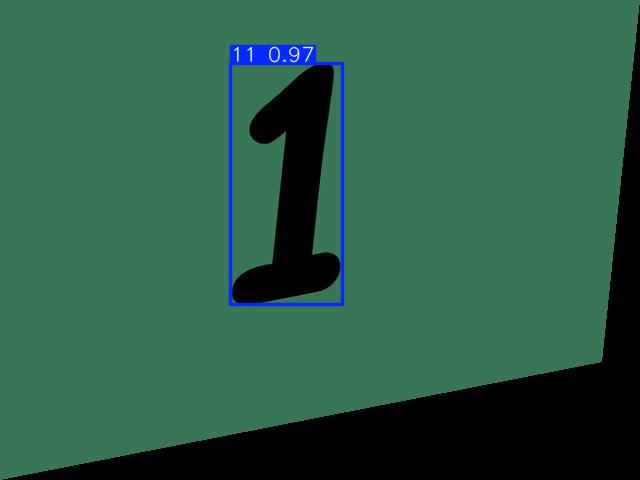

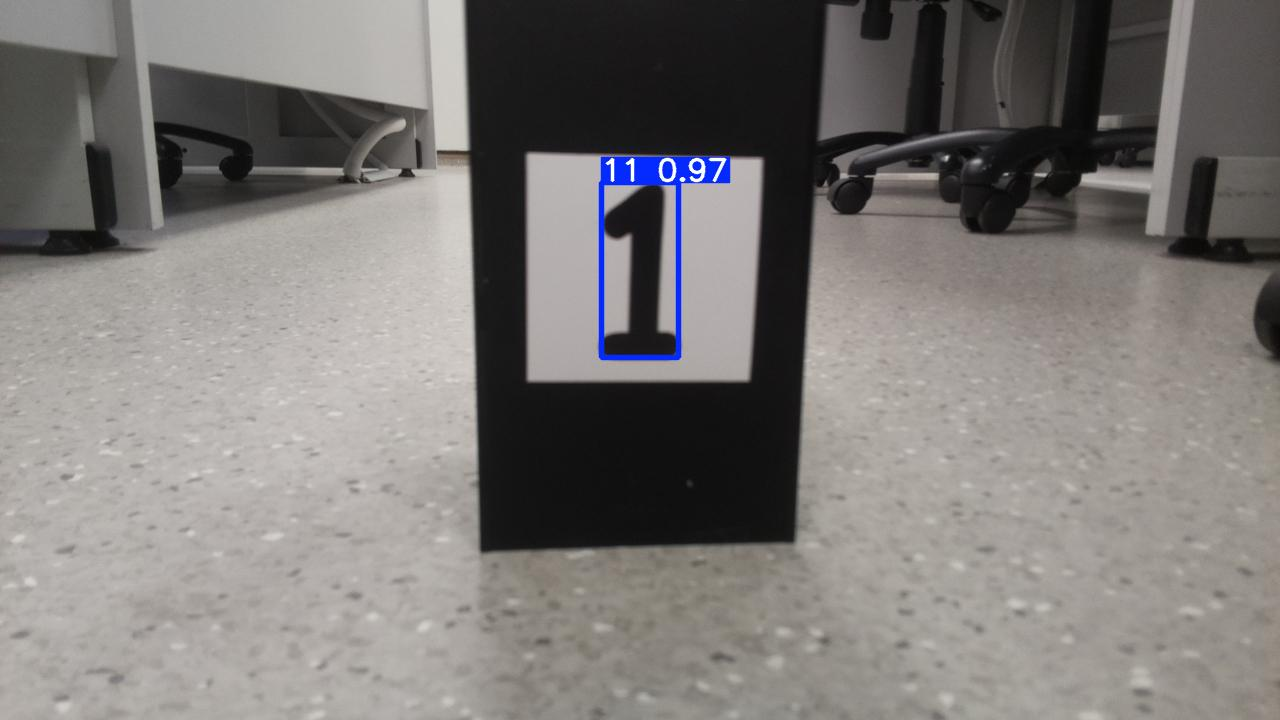

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_123


✅ Class 12: saved 3 preds to /content/yolov5/runs/detect_by_class/class_12


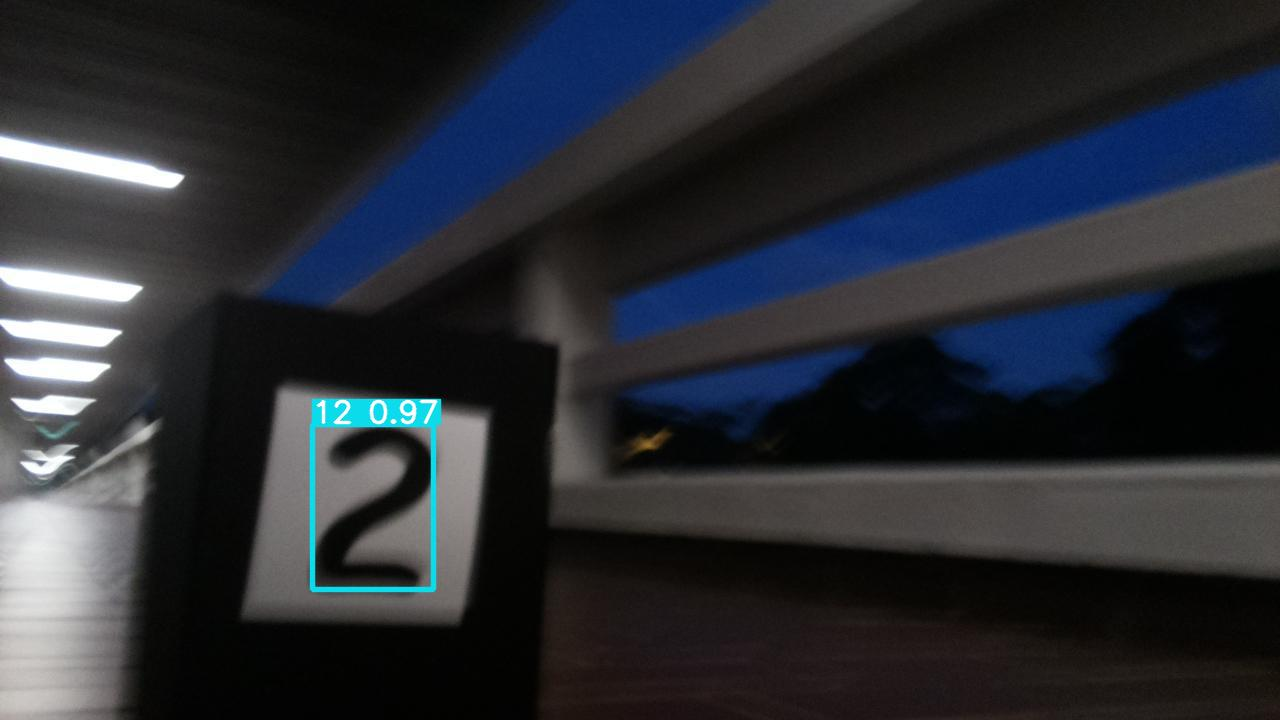

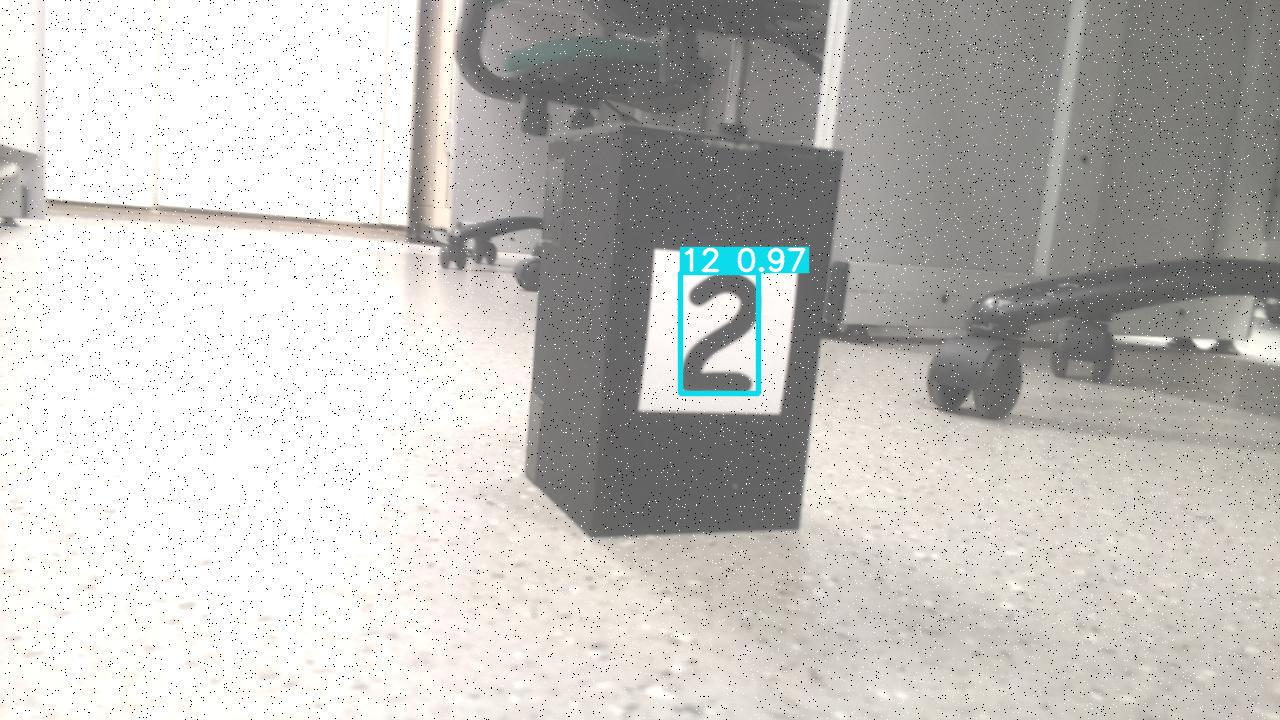

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_133


✅ Class 13: saved 3 preds to /content/yolov5/runs/detect_by_class/class_13


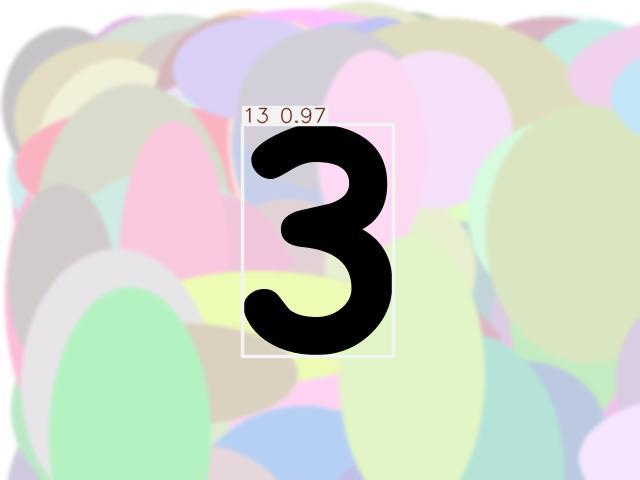

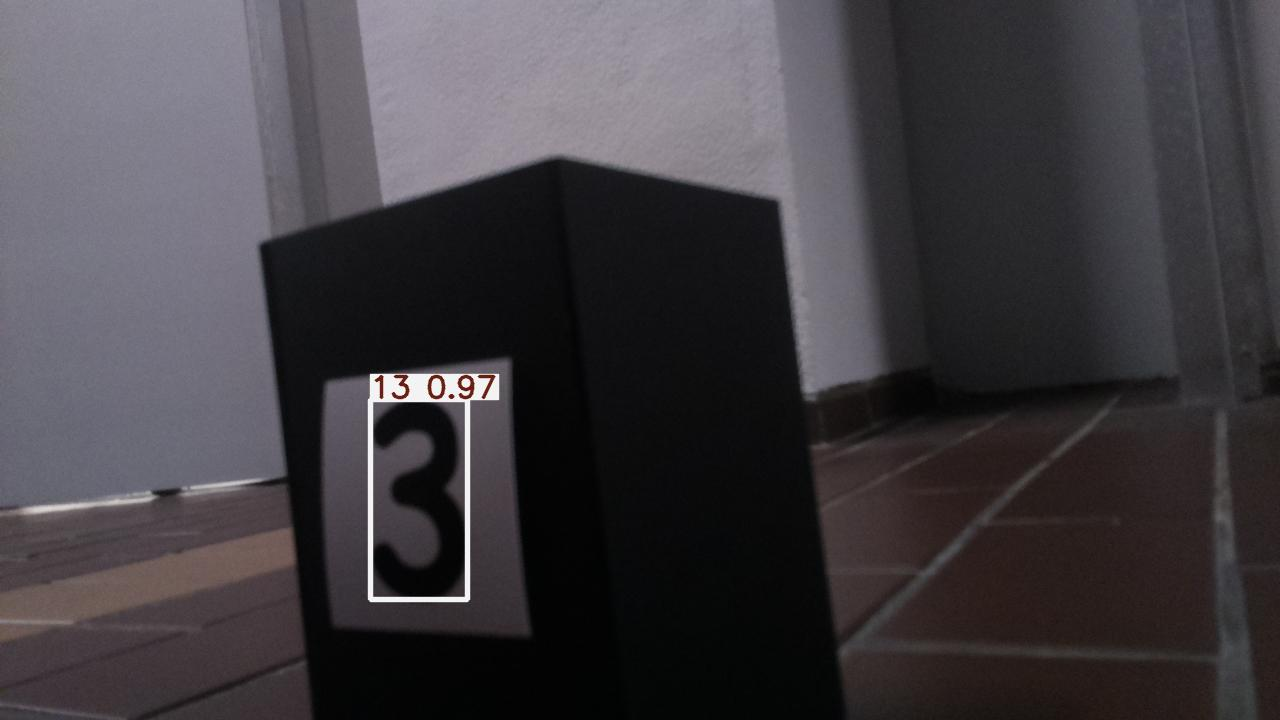

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_143


✅ Class 14: saved 3 preds to /content/yolov5/runs/detect_by_class/class_14


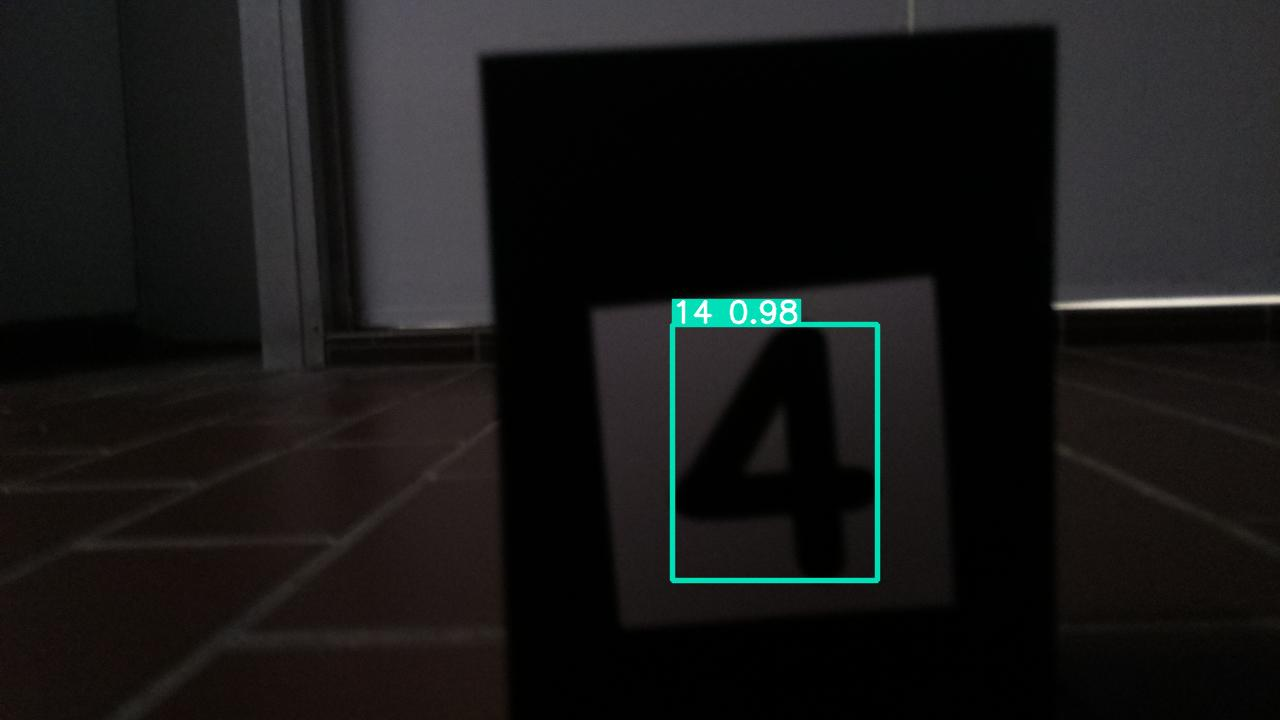

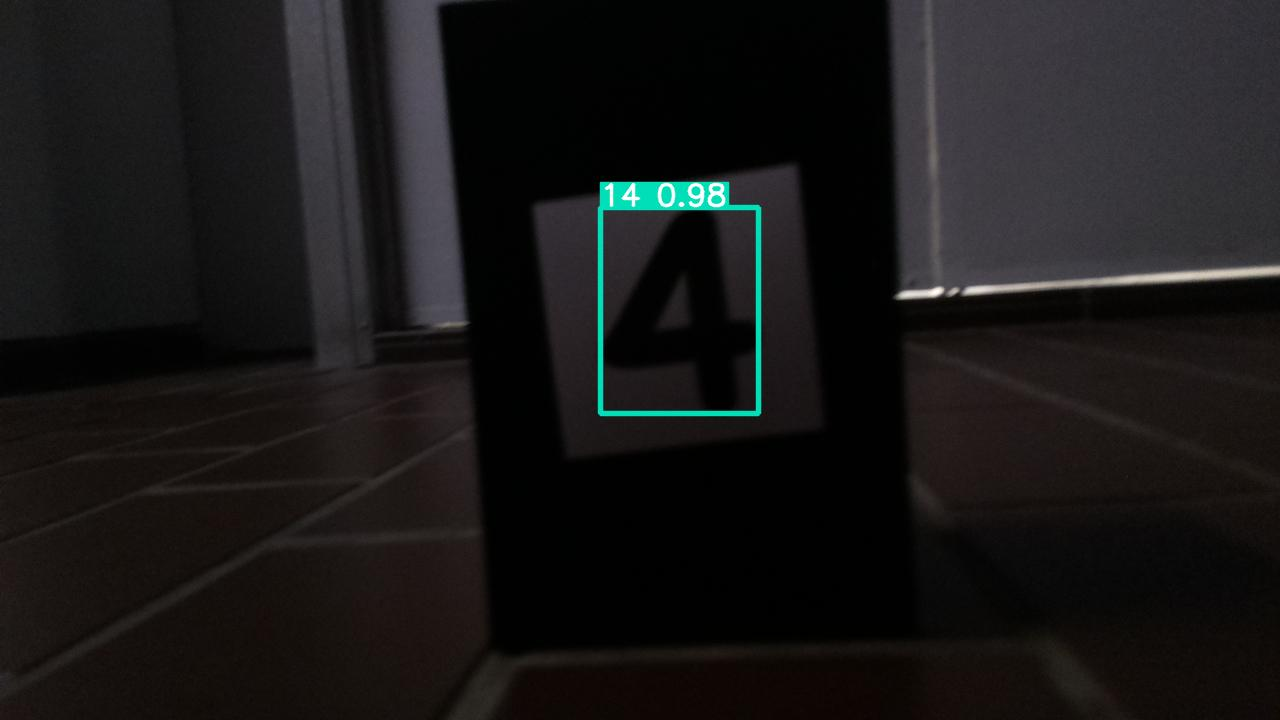

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_153


✅ Class 15: saved 3 preds to /content/yolov5/runs/detect_by_class/class_15


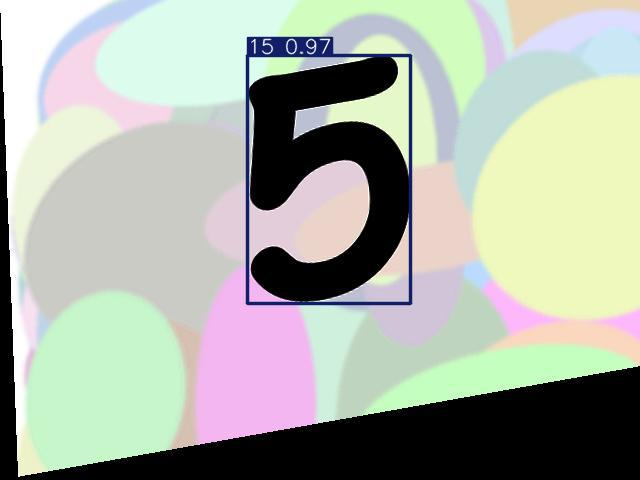

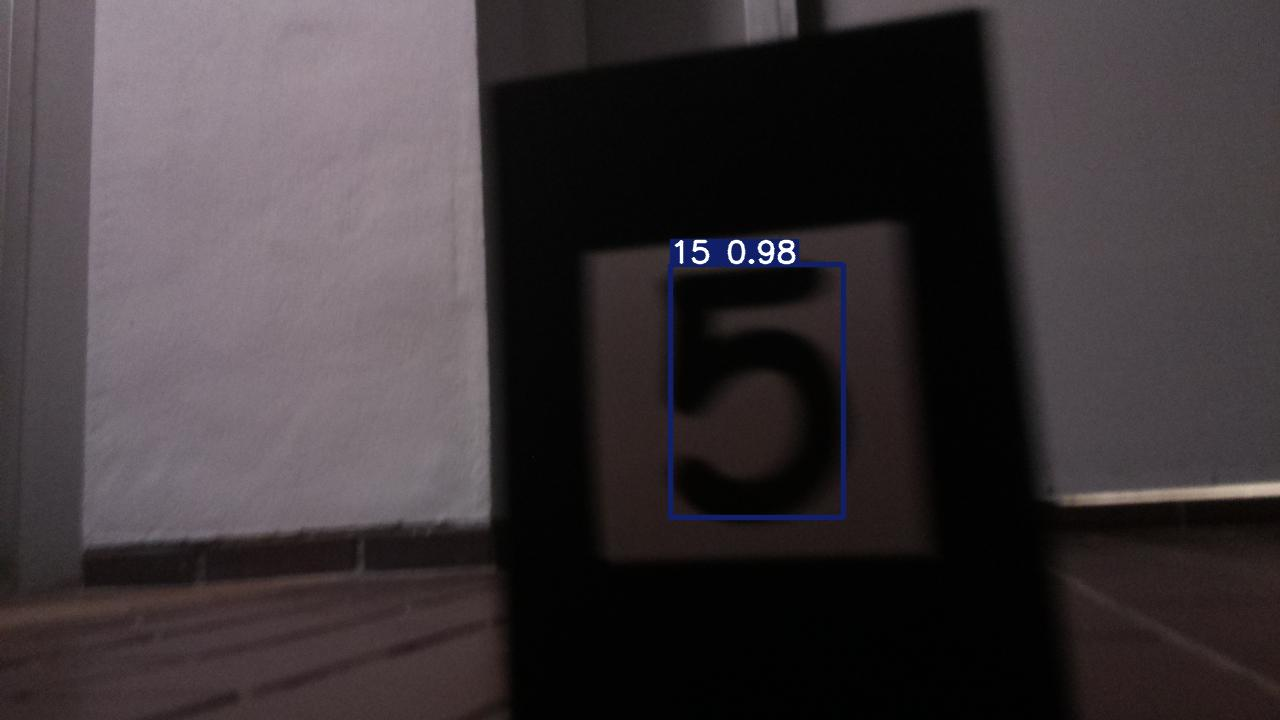

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_163


✅ Class 16: saved 3 preds to /content/yolov5/runs/detect_by_class/class_16


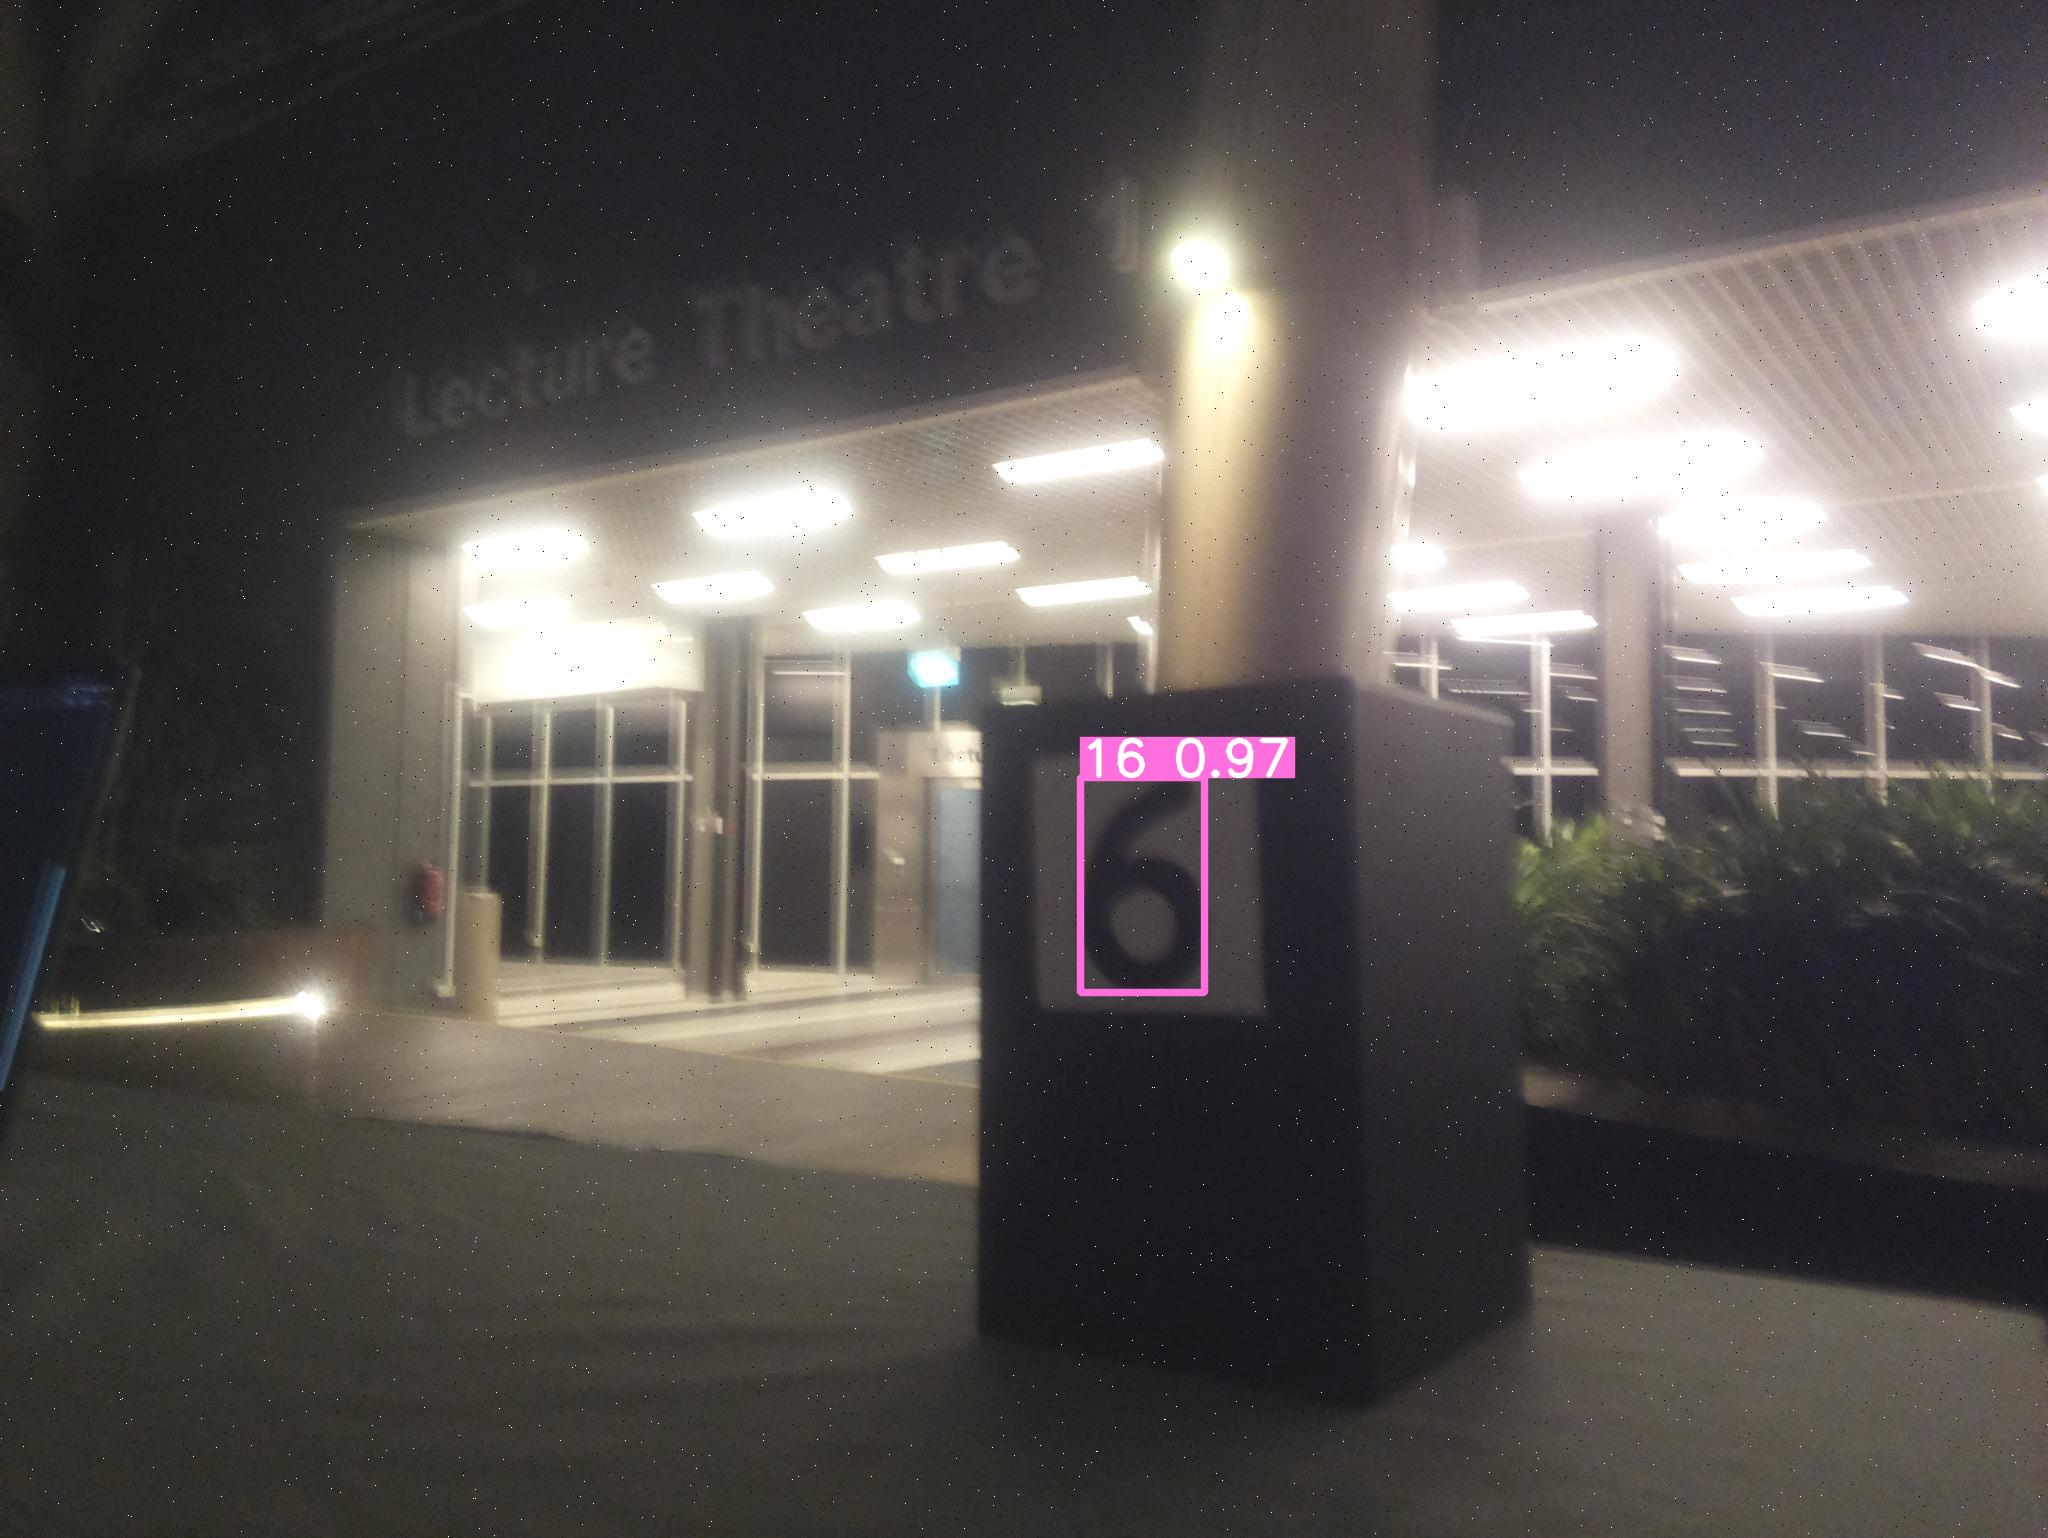

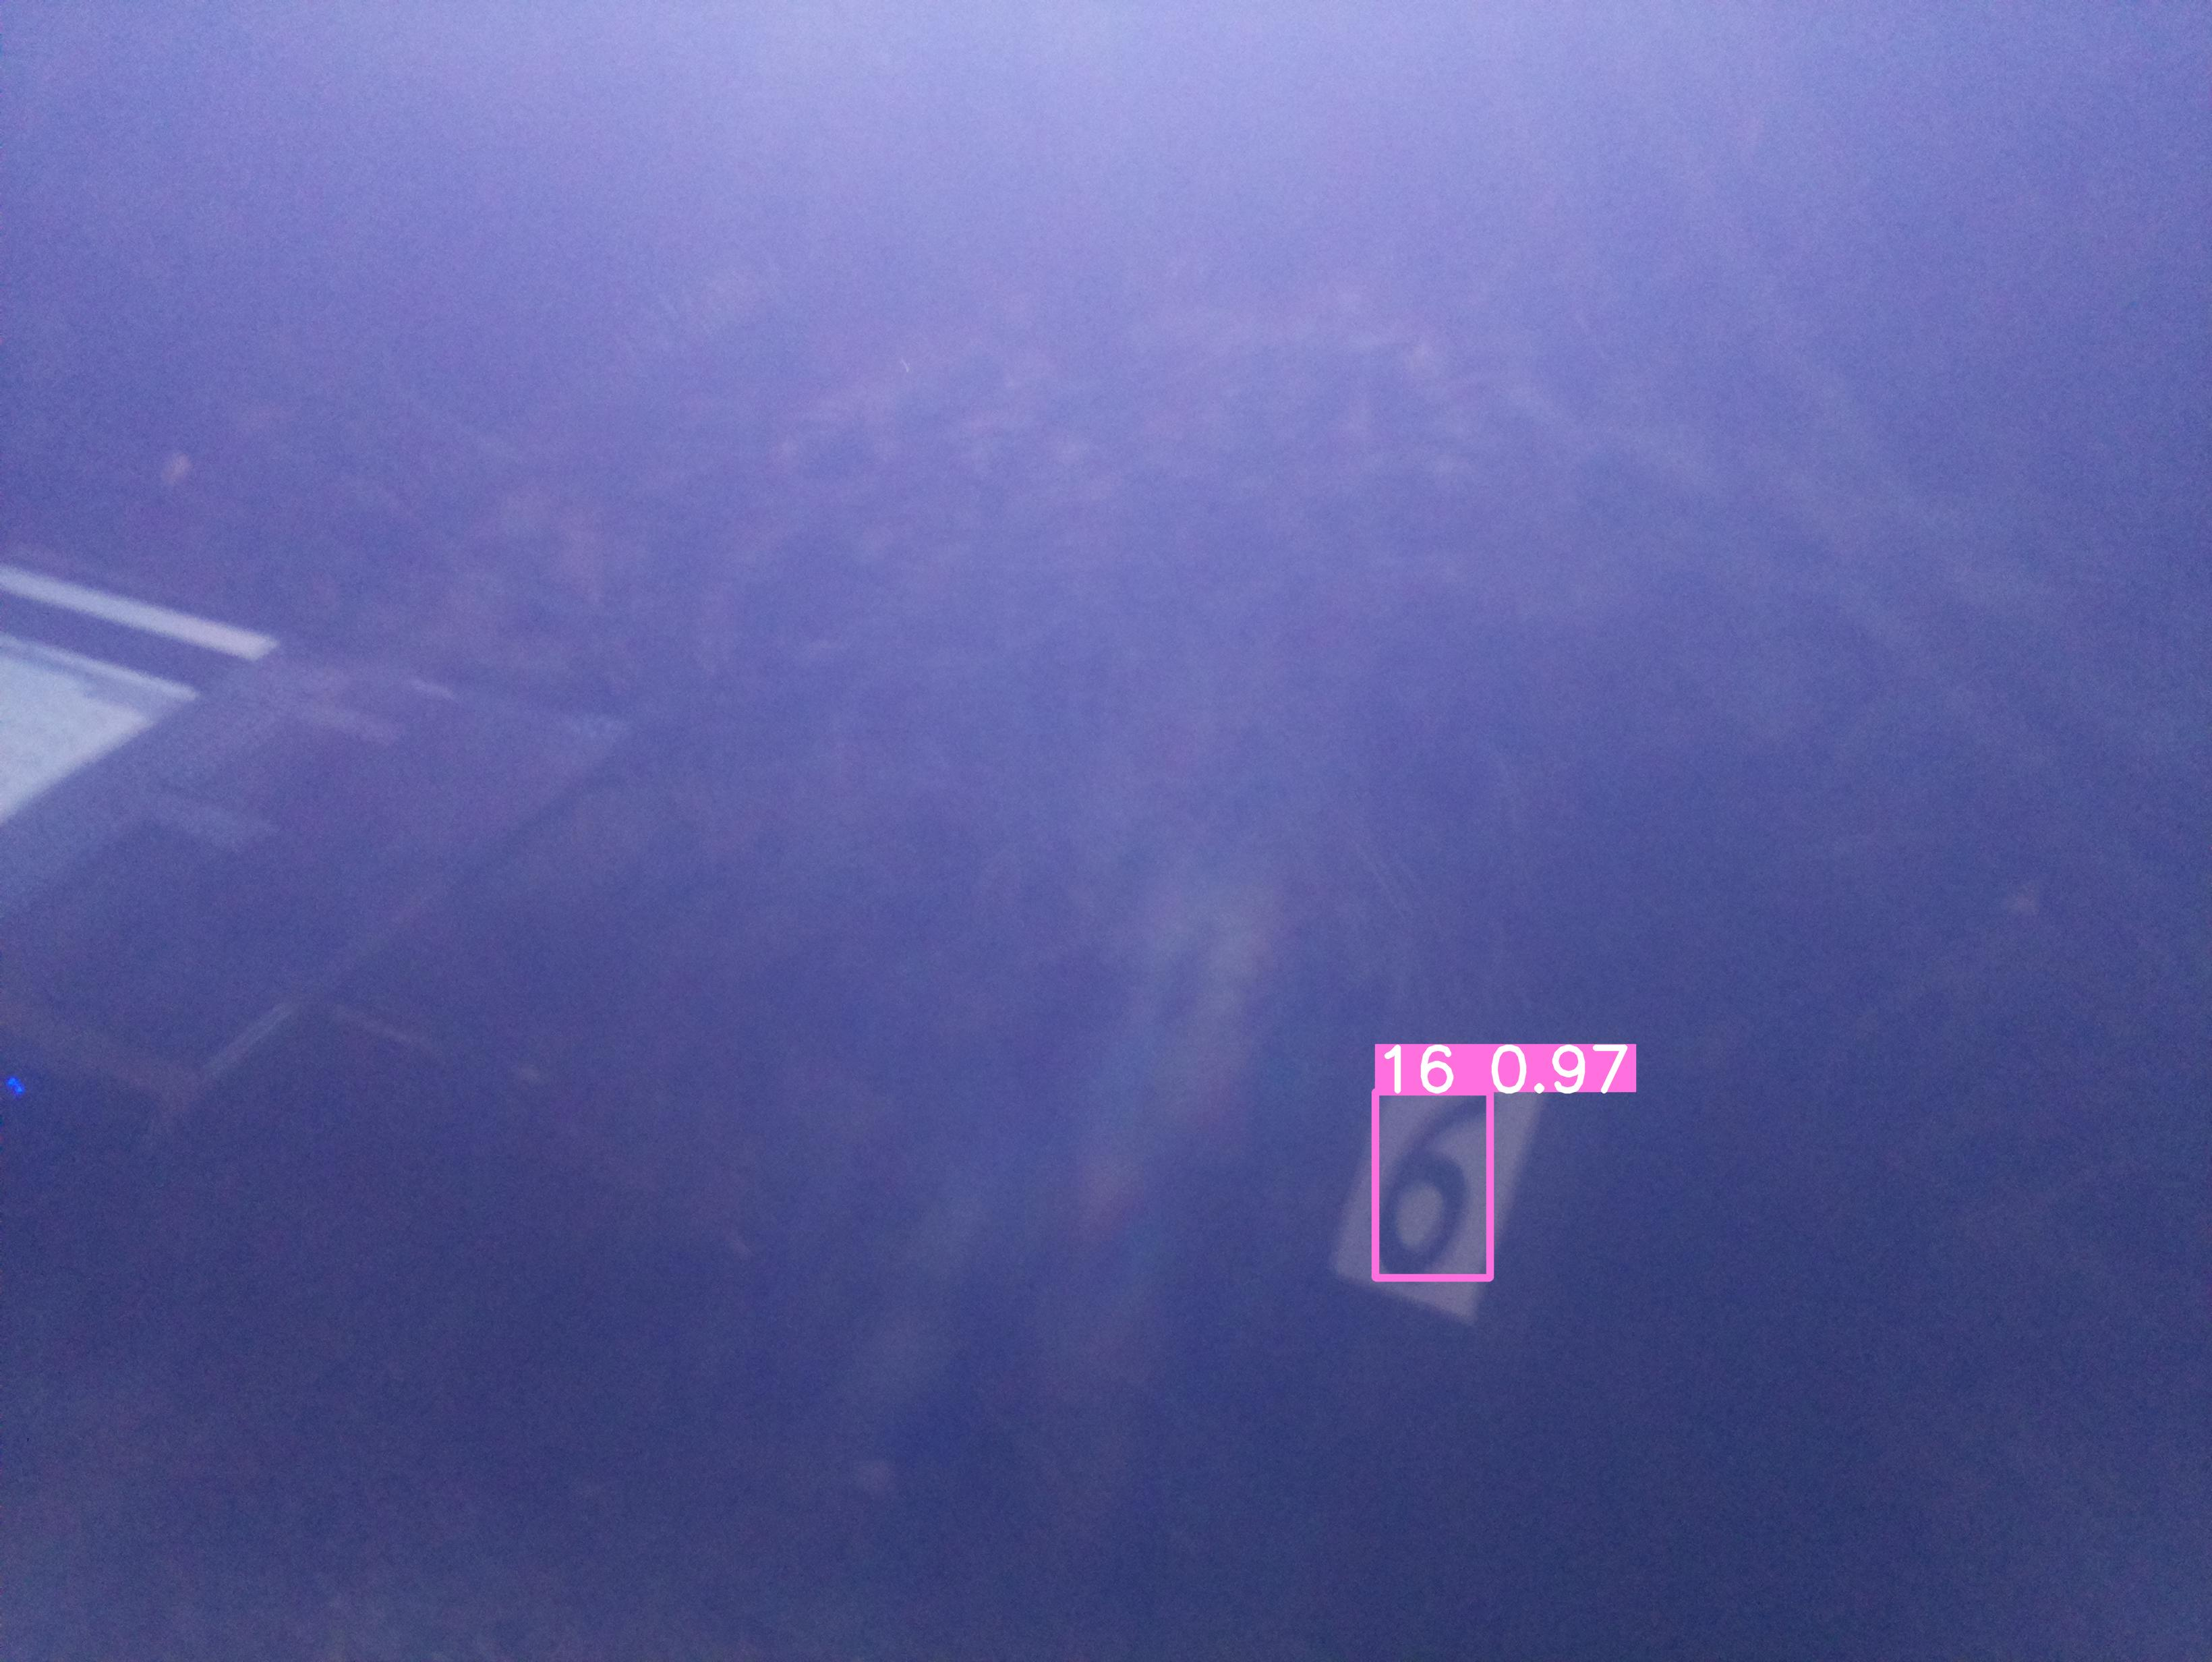

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_173


✅ Class 17: saved 3 preds to /content/yolov5/runs/detect_by_class/class_17


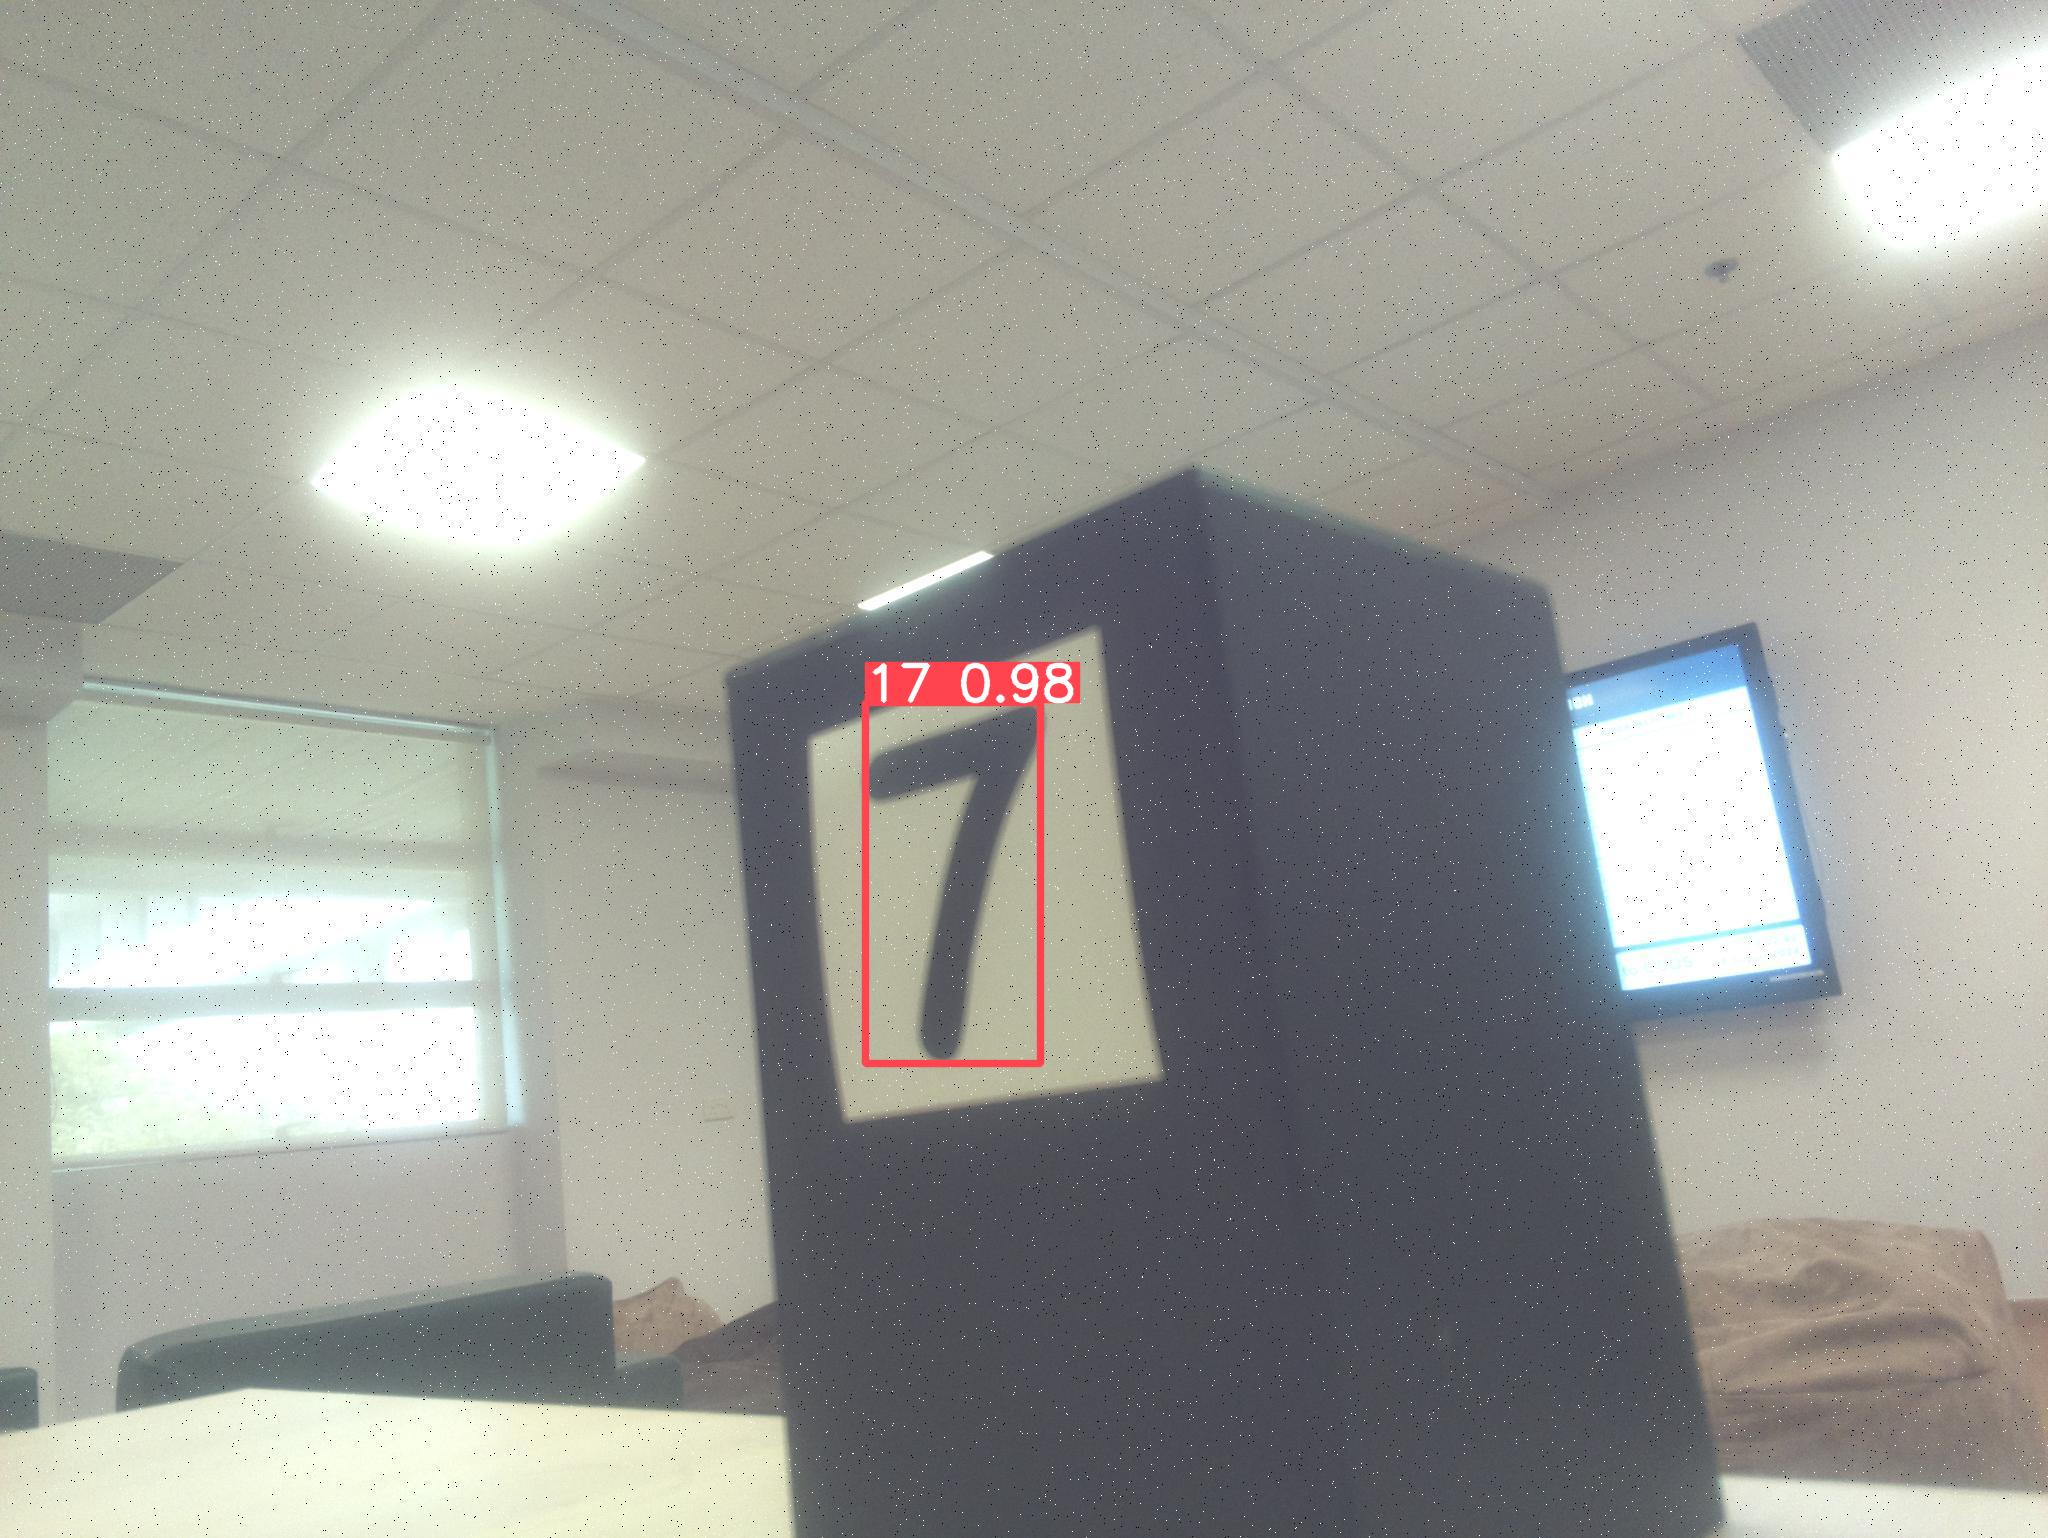

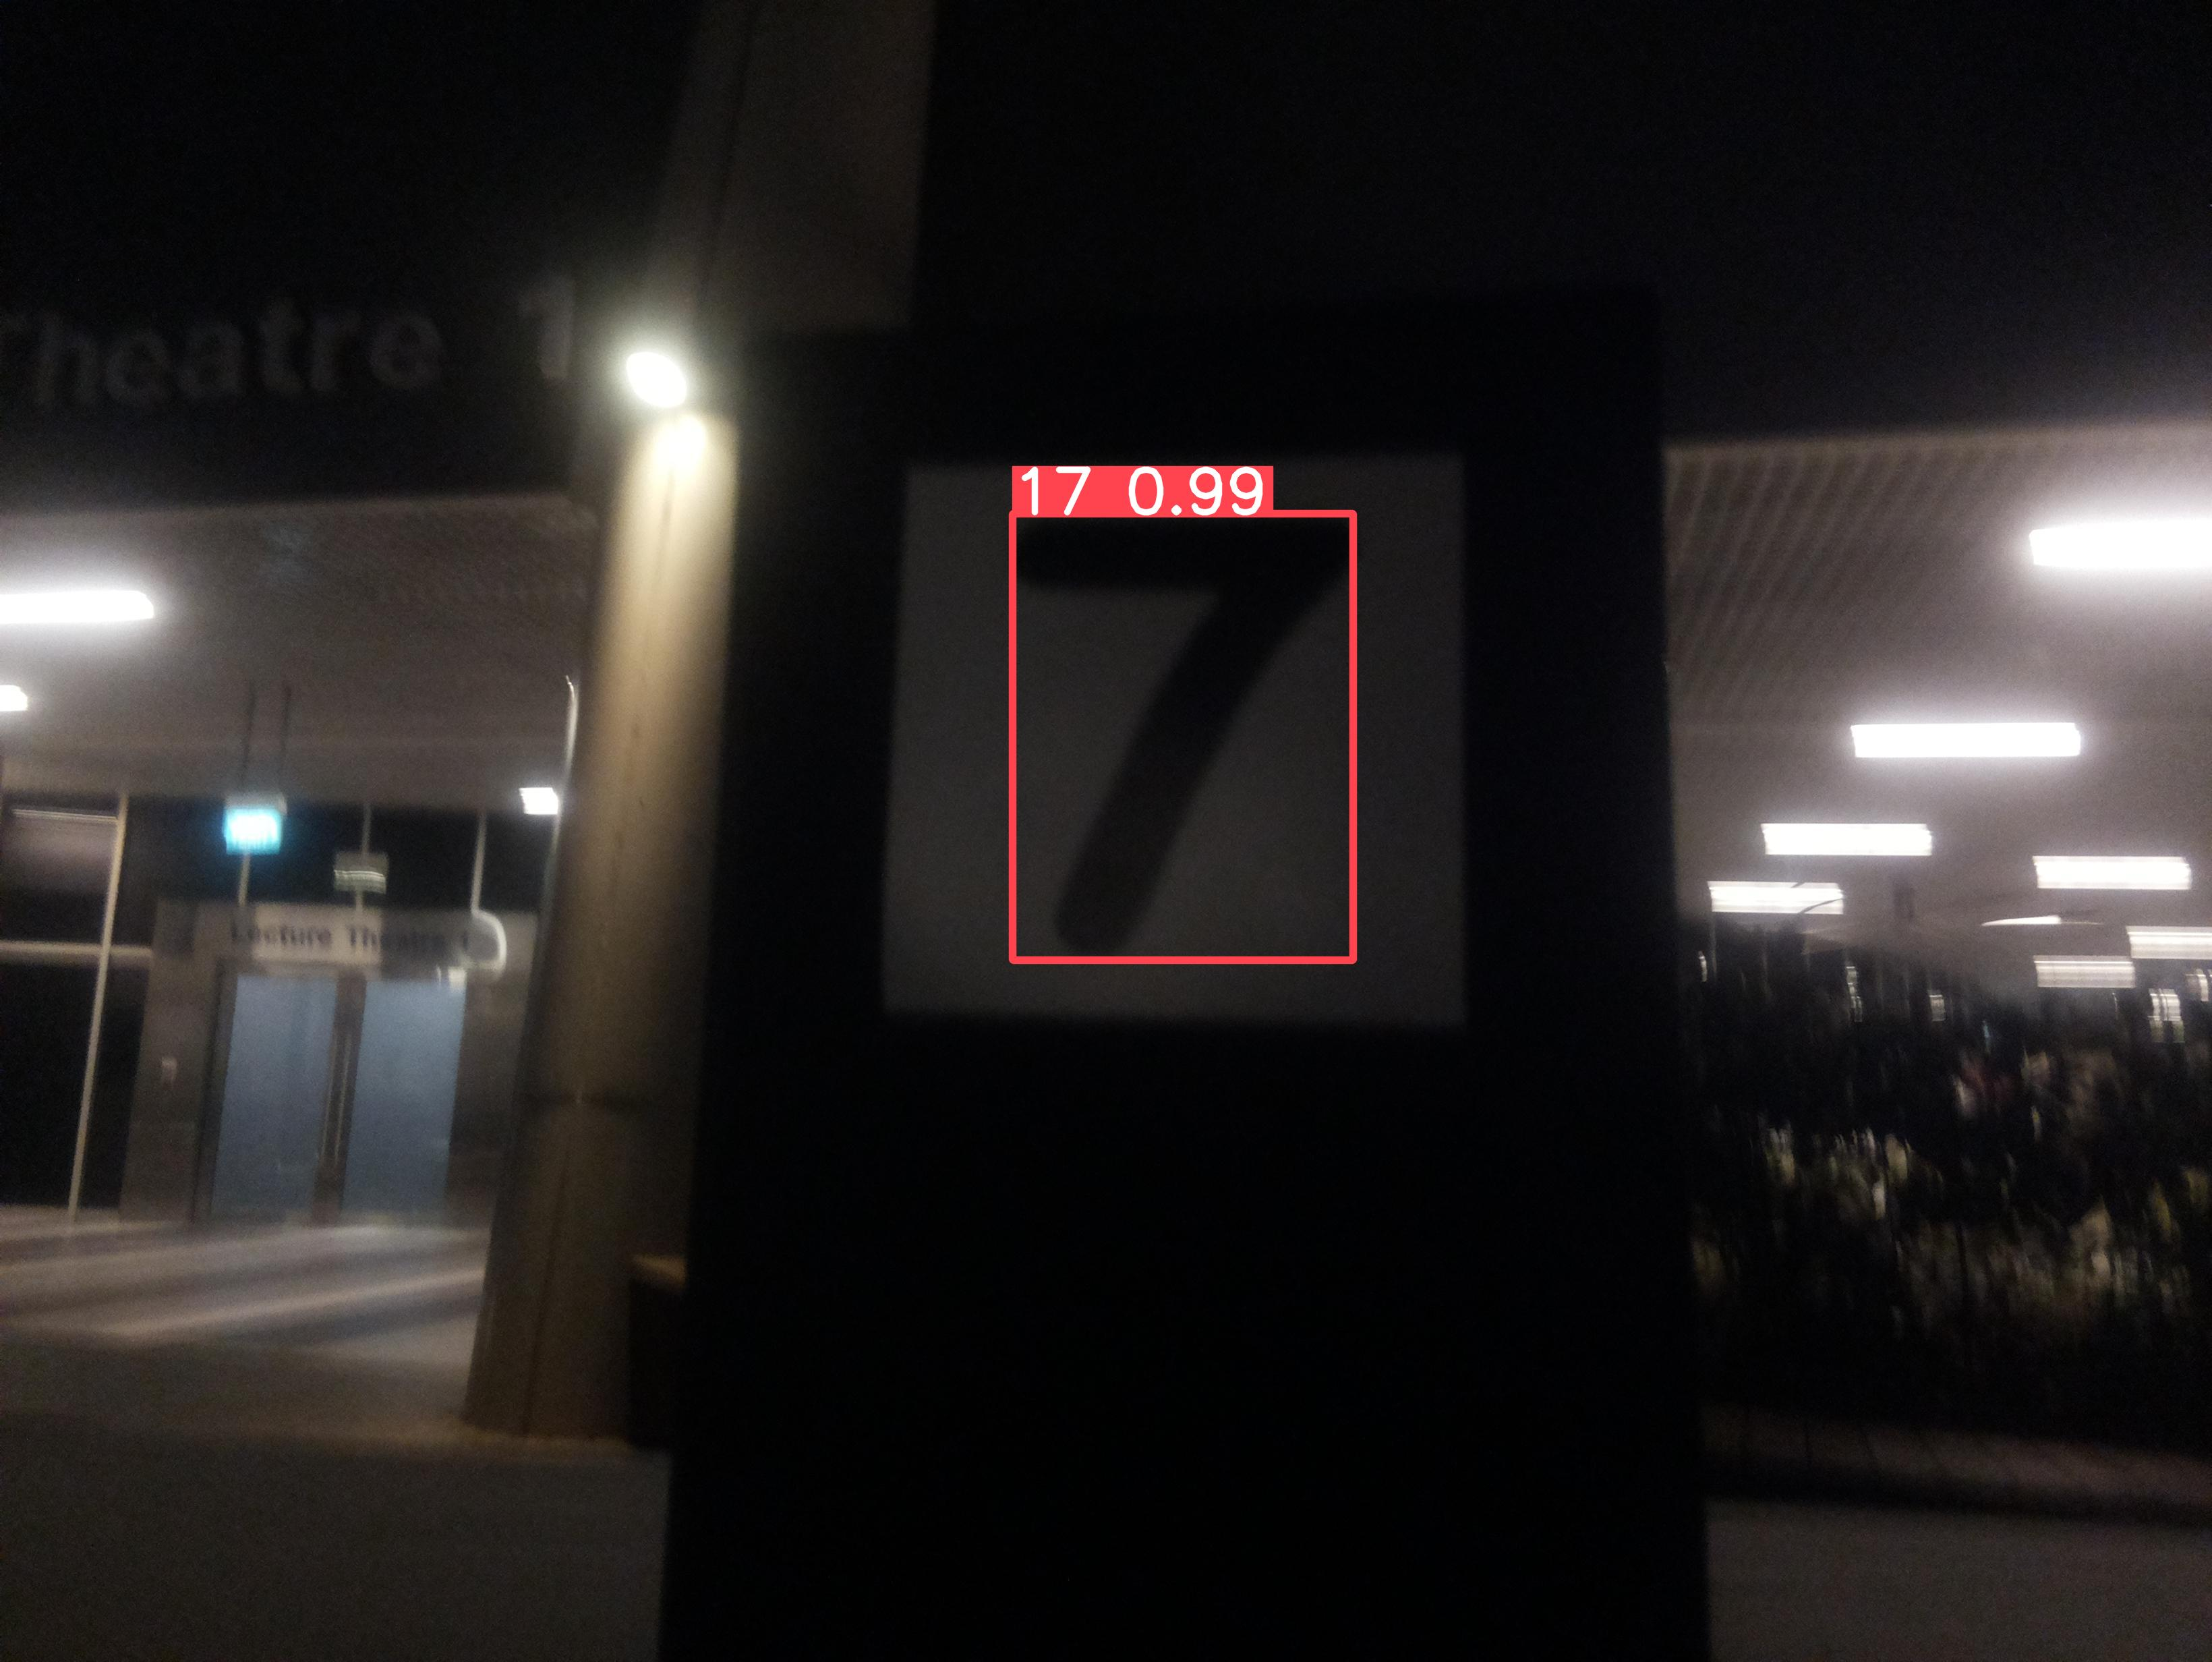

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_183


✅ Class 18: saved 3 preds to /content/yolov5/runs/detect_by_class/class_18


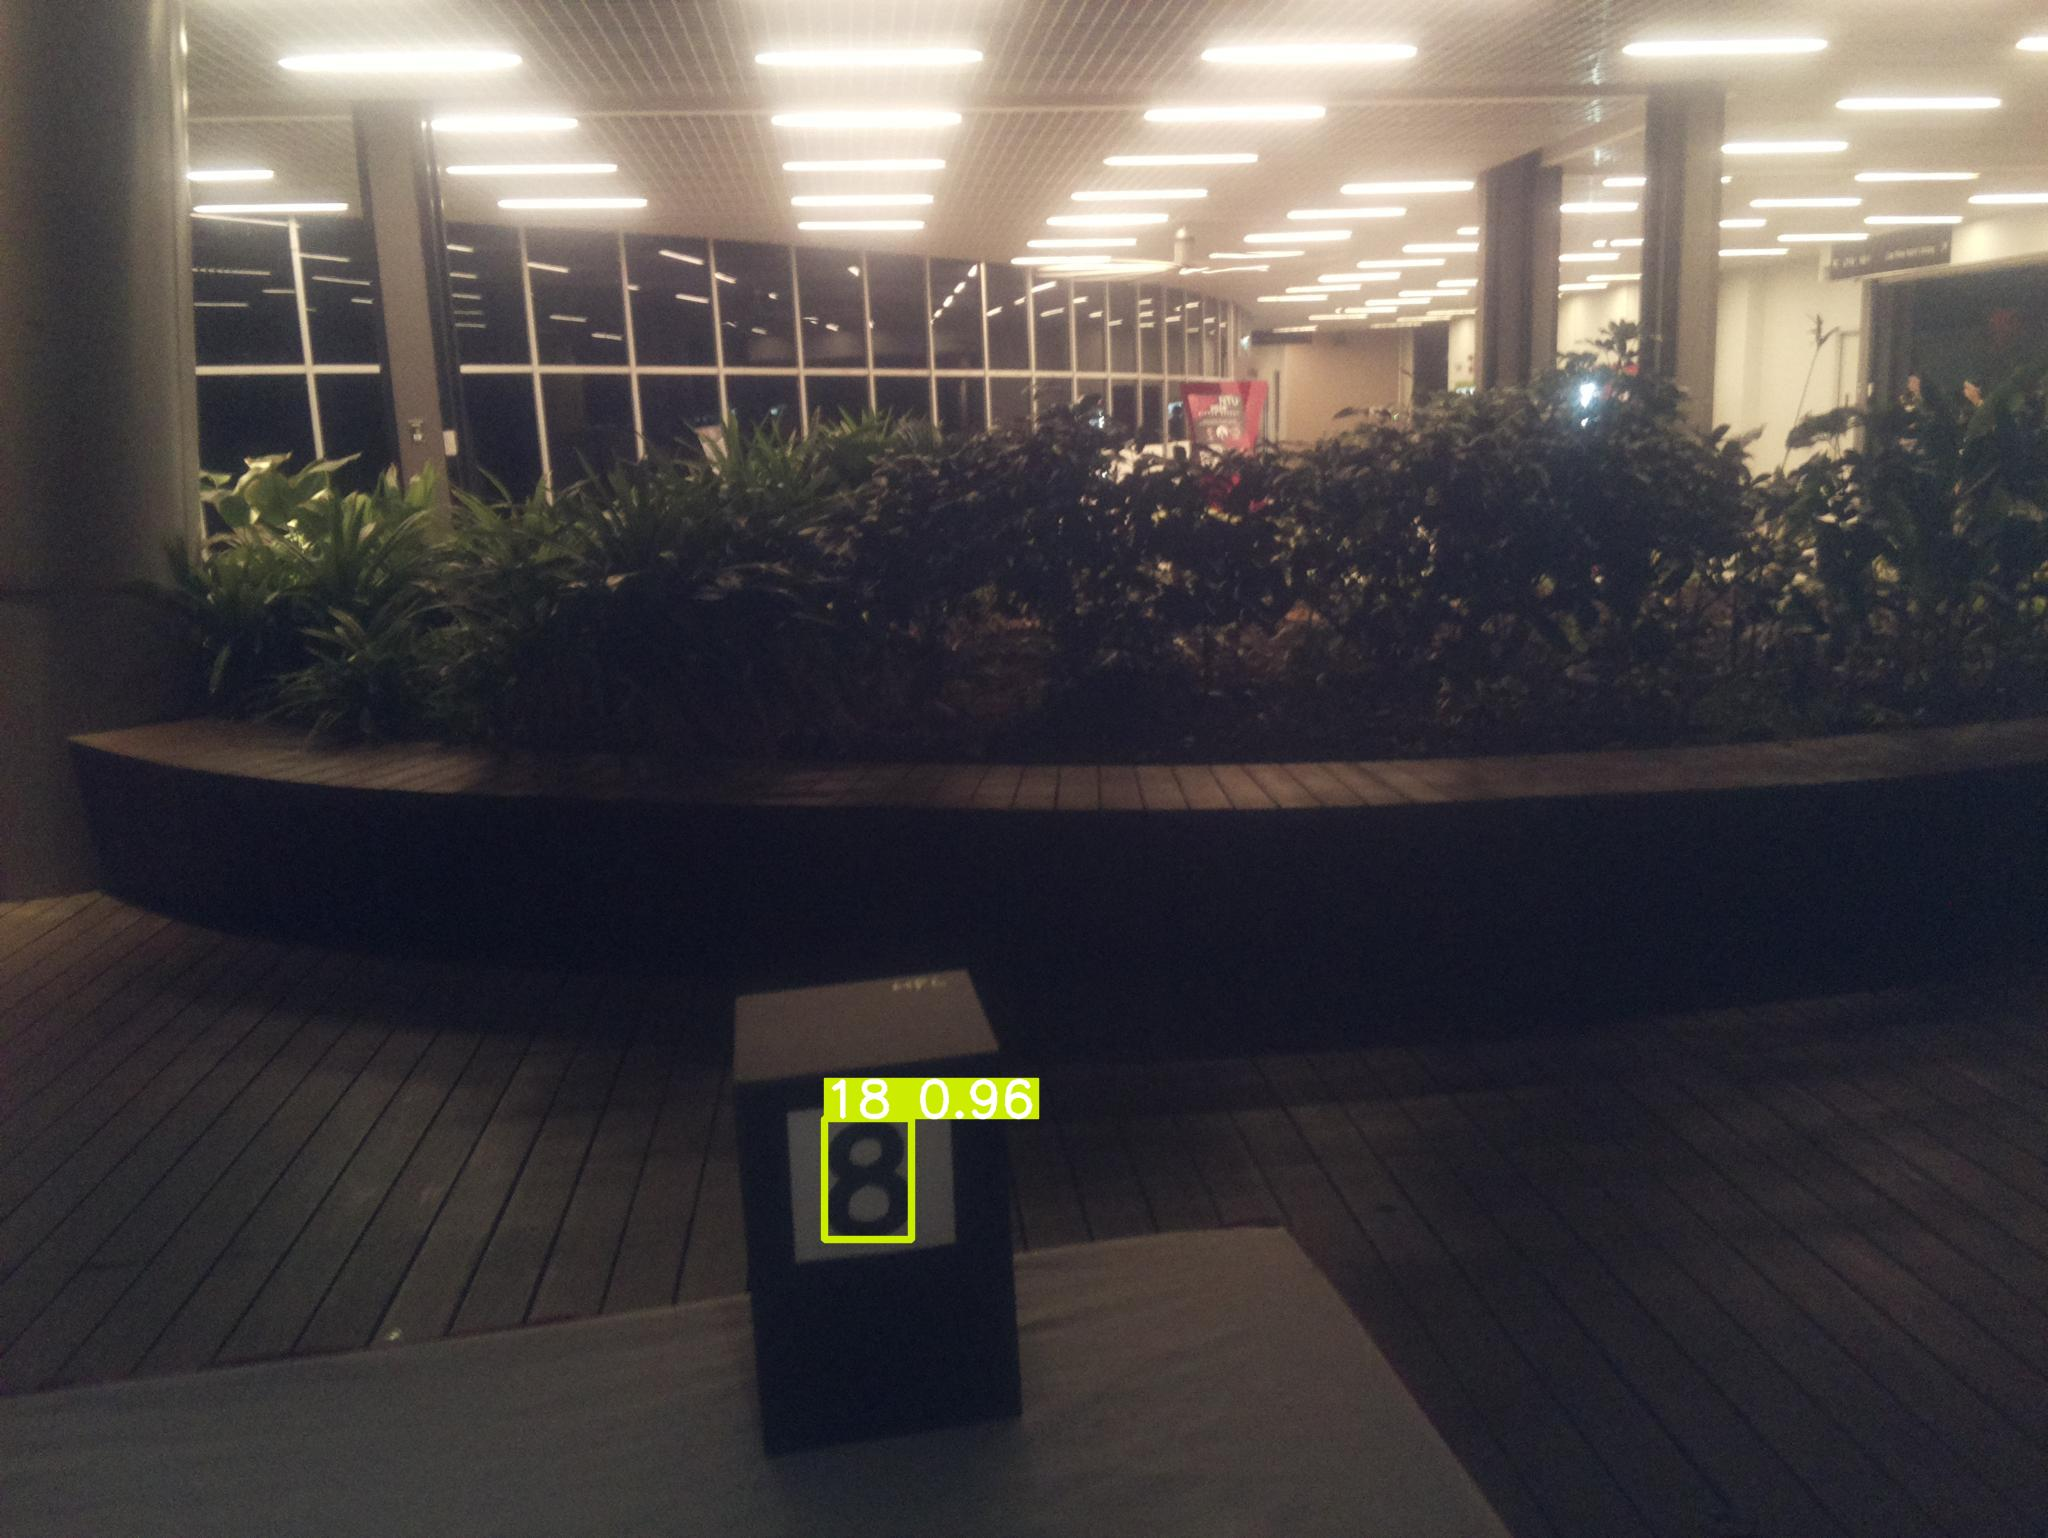

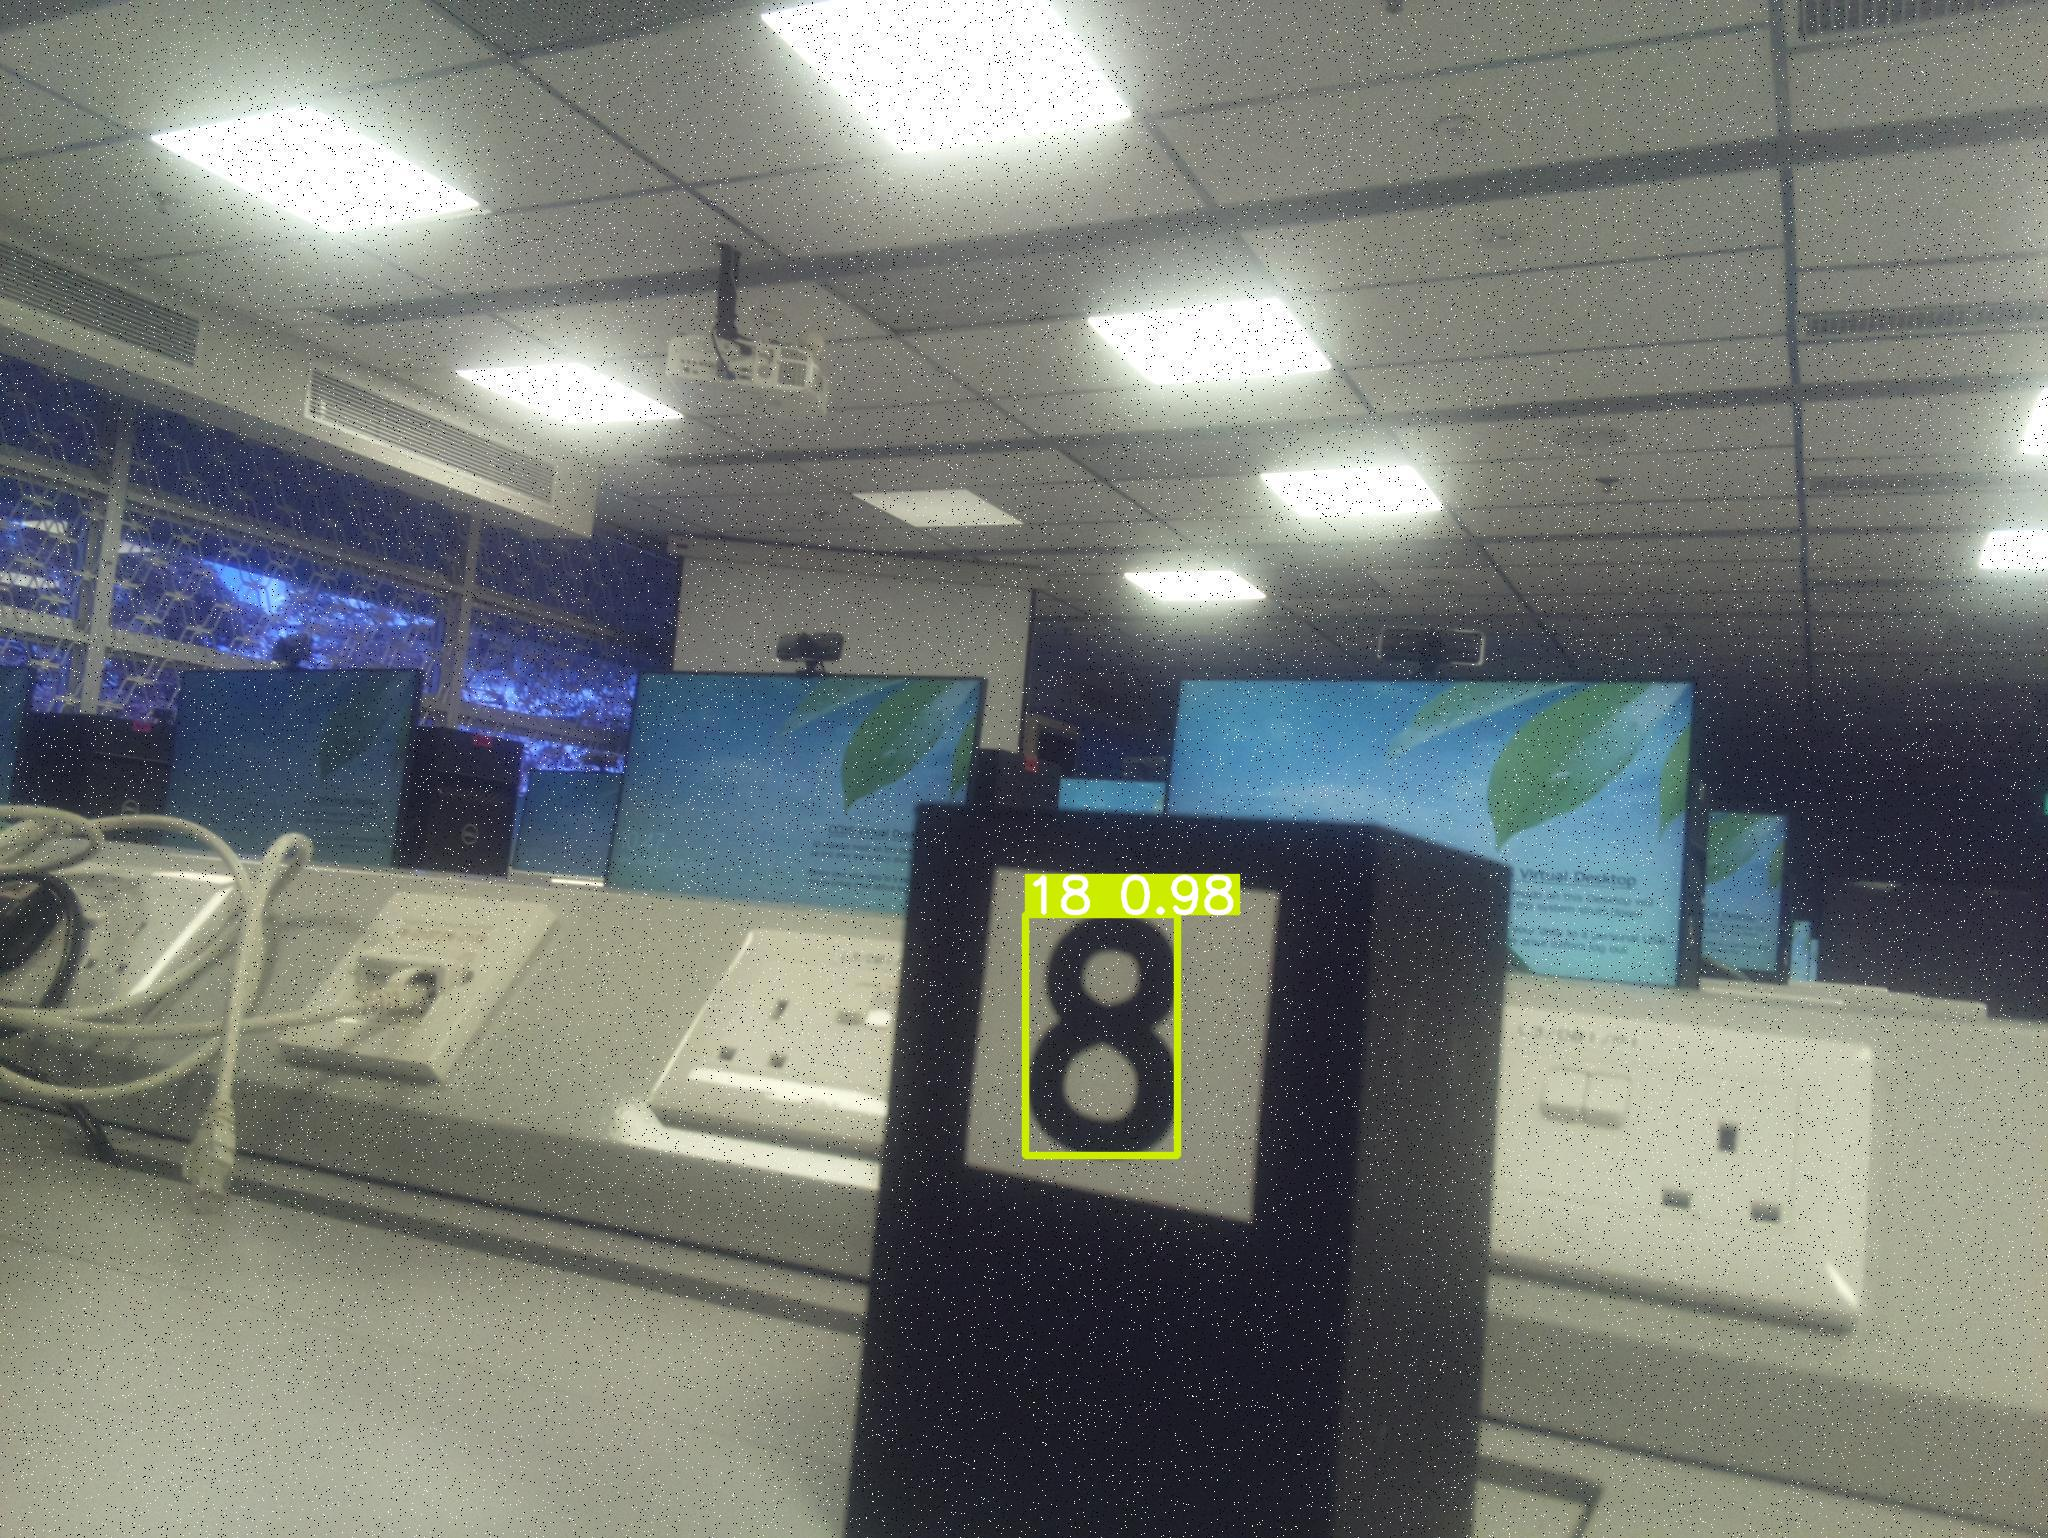

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_193


✅ Class 19: saved 3 preds to /content/yolov5/runs/detect_by_class/class_19


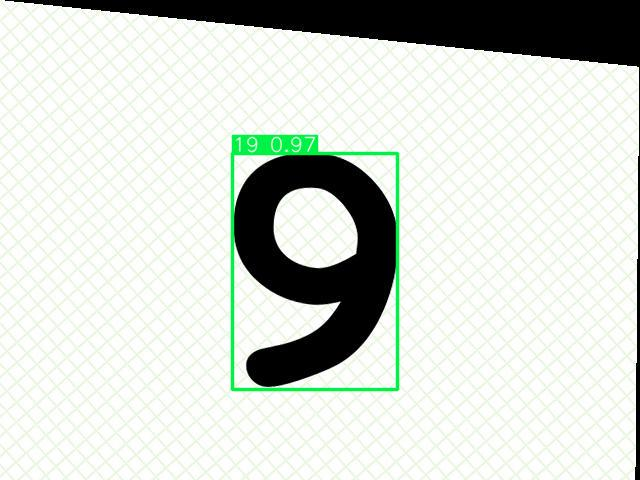

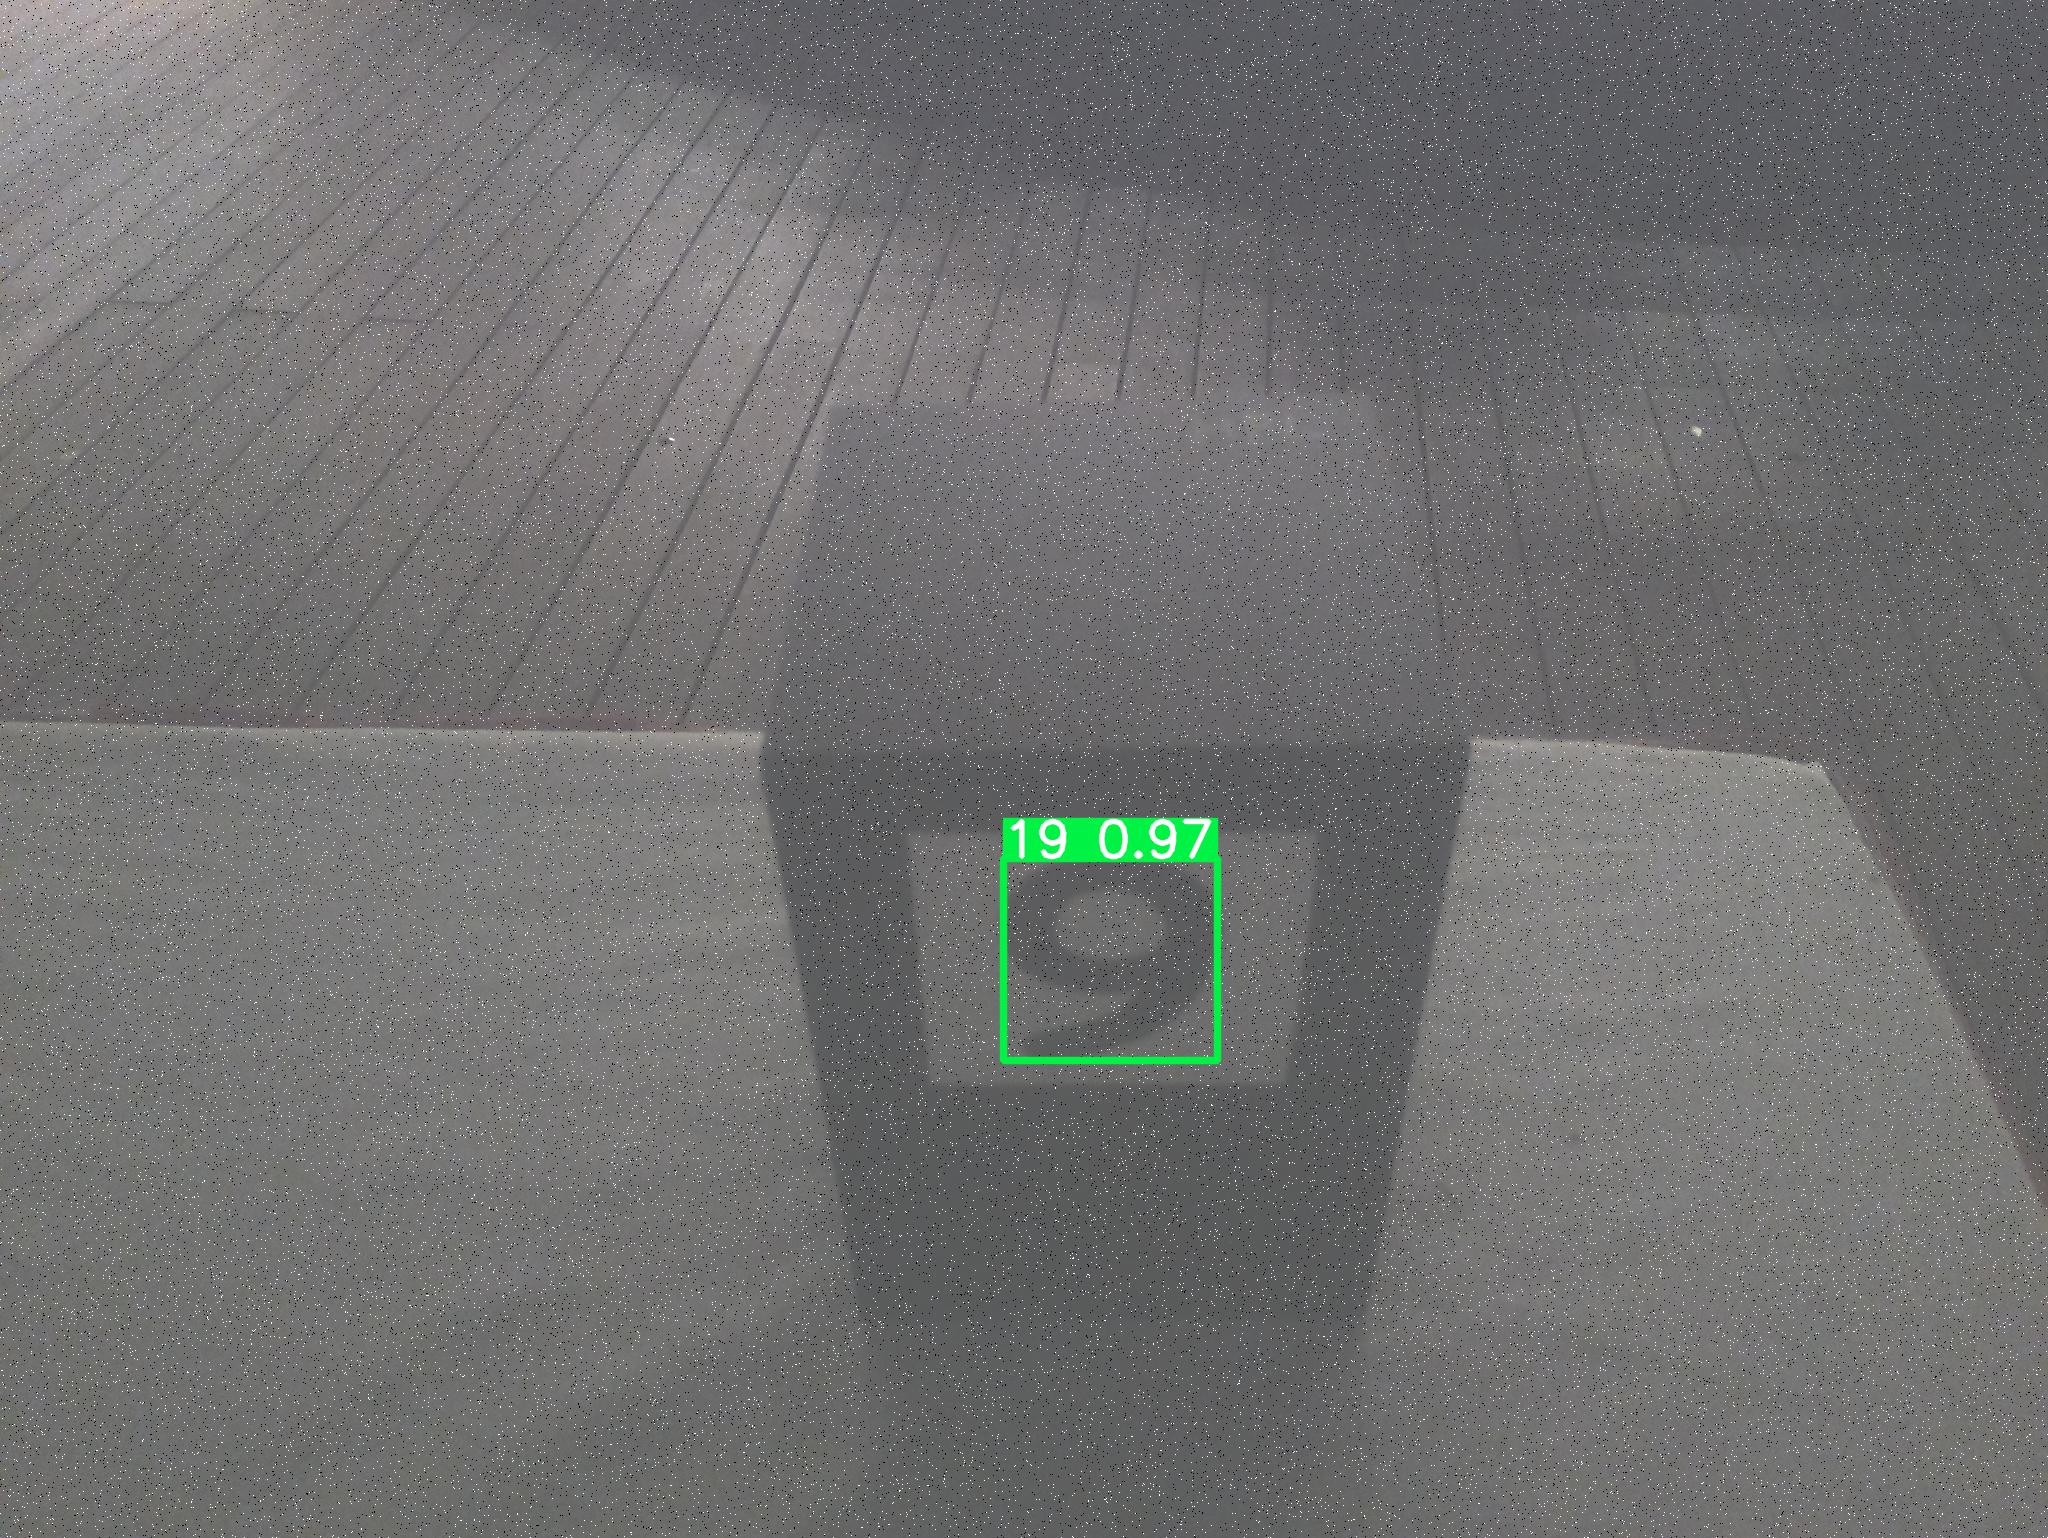

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_203


✅ Class 20: saved 3 preds to /content/yolov5/runs/detect_by_class/class_20


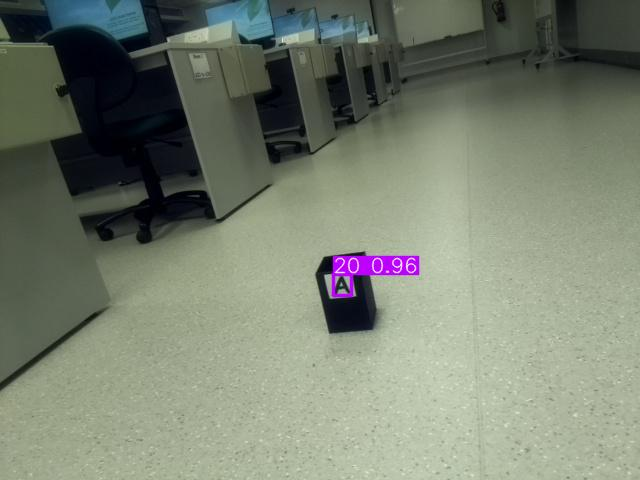

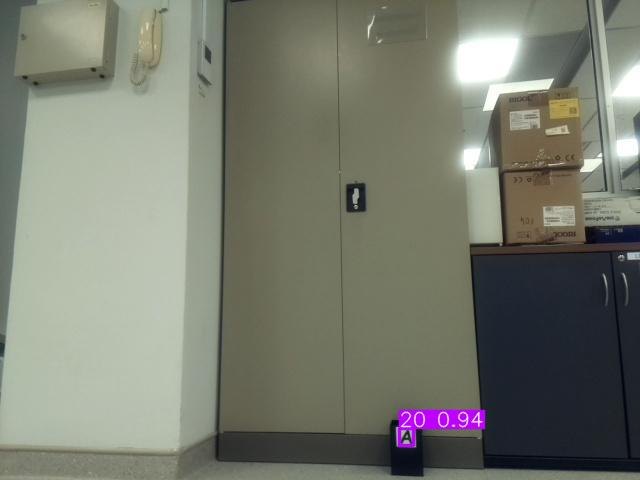

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_213


✅ Class 21: saved 3 preds to /content/yolov5/runs/detect_by_class/class_21


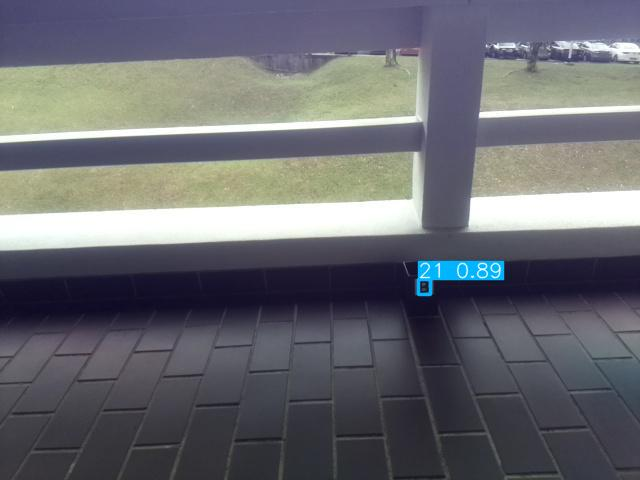

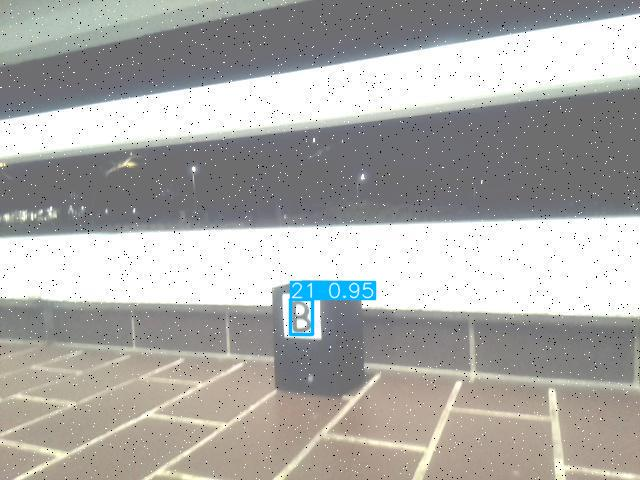

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_223


✅ Class 22: saved 3 preds to /content/yolov5/runs/detect_by_class/class_22


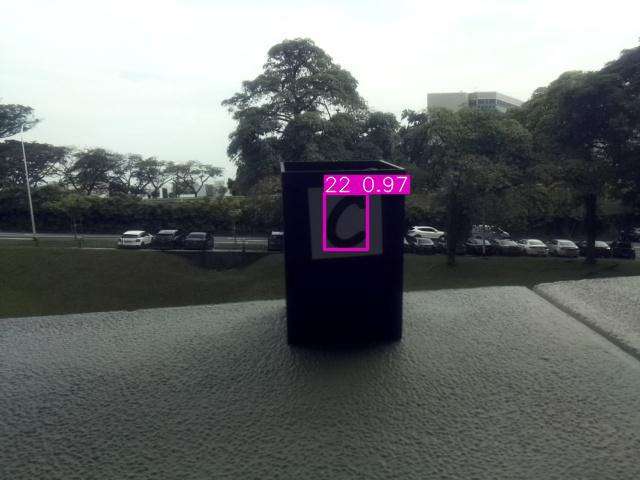

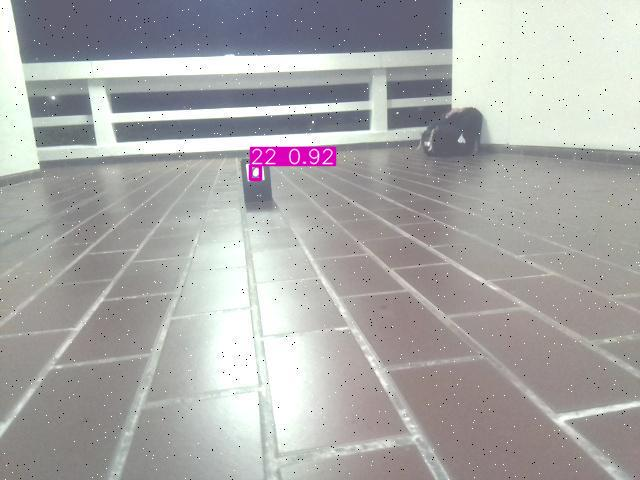

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_233


✅ Class 23: saved 3 preds to /content/yolov5/runs/detect_by_class/class_23


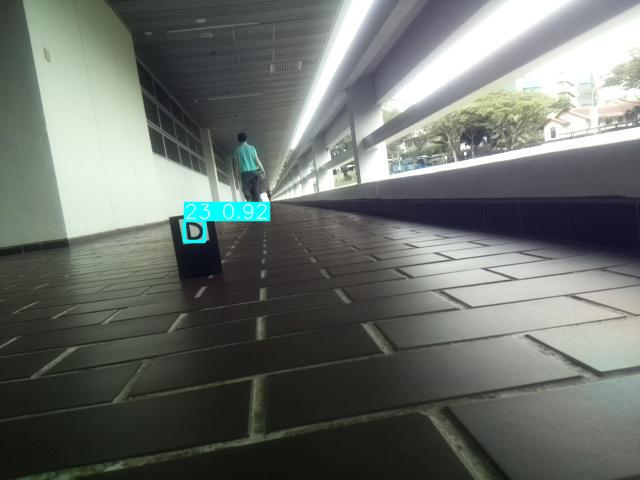

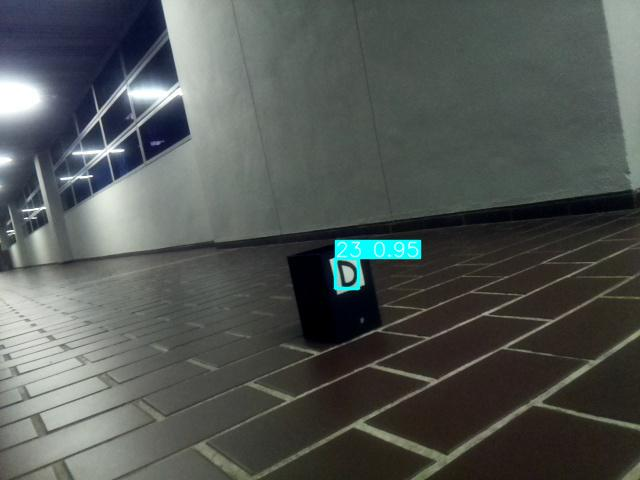

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_243


✅ Class 24: saved 3 preds to /content/yolov5/runs/detect_by_class/class_24


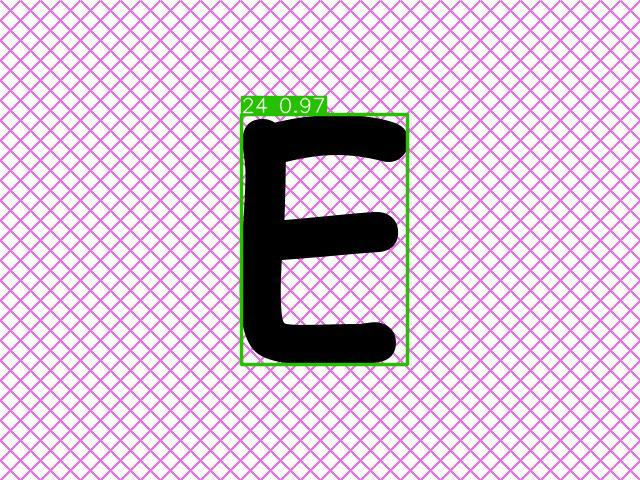

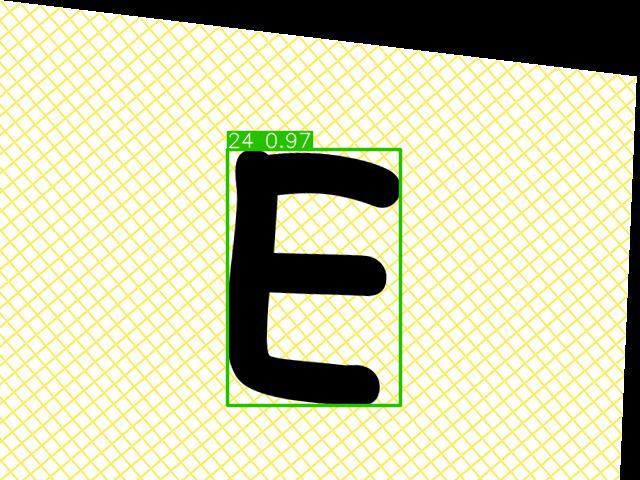

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_253


✅ Class 25: saved 3 preds to /content/yolov5/runs/detect_by_class/class_25


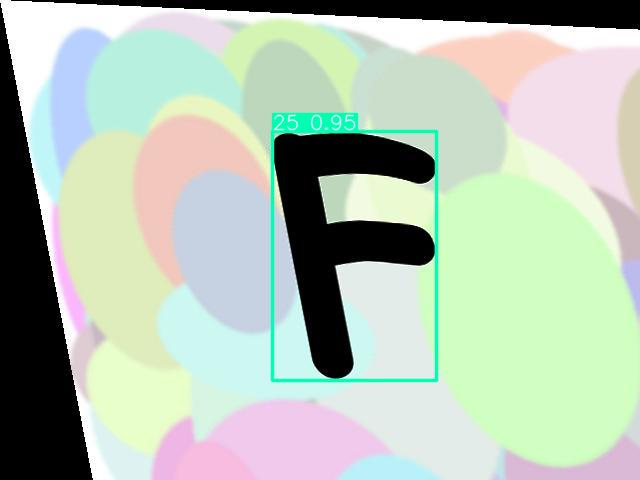

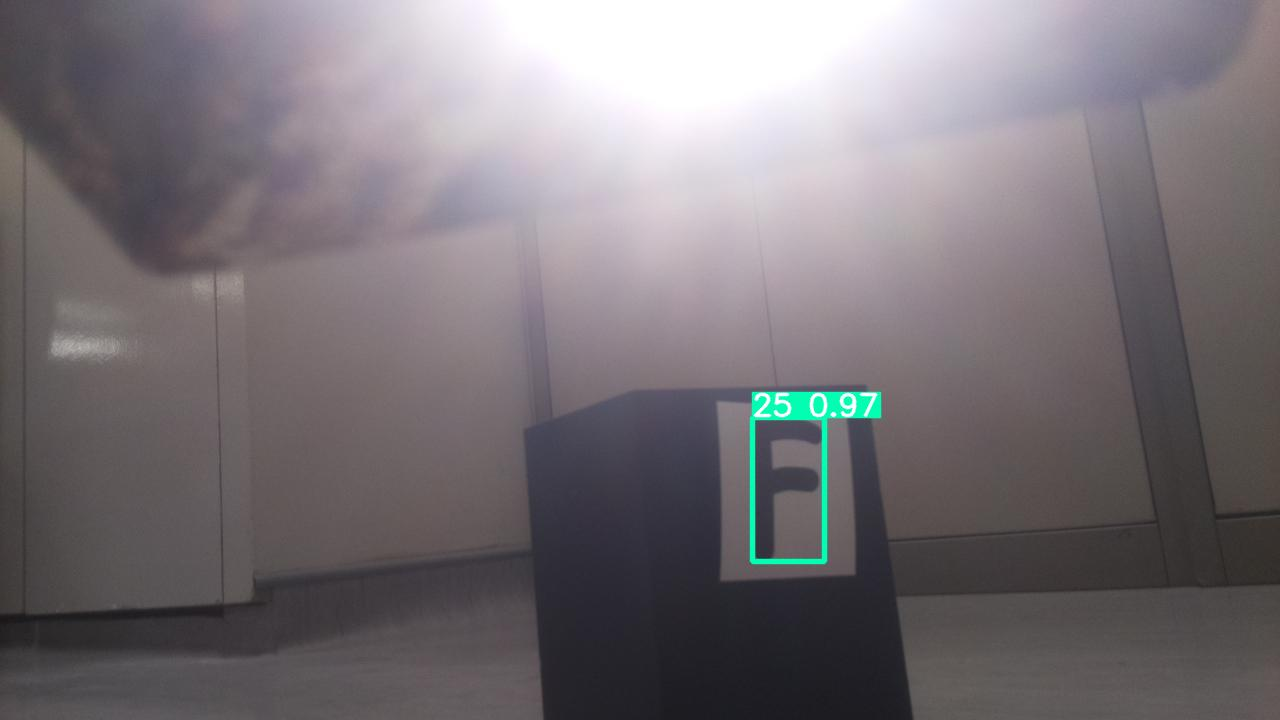

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_263


✅ Class 26: saved 3 preds to /content/yolov5/runs/detect_by_class/class_26


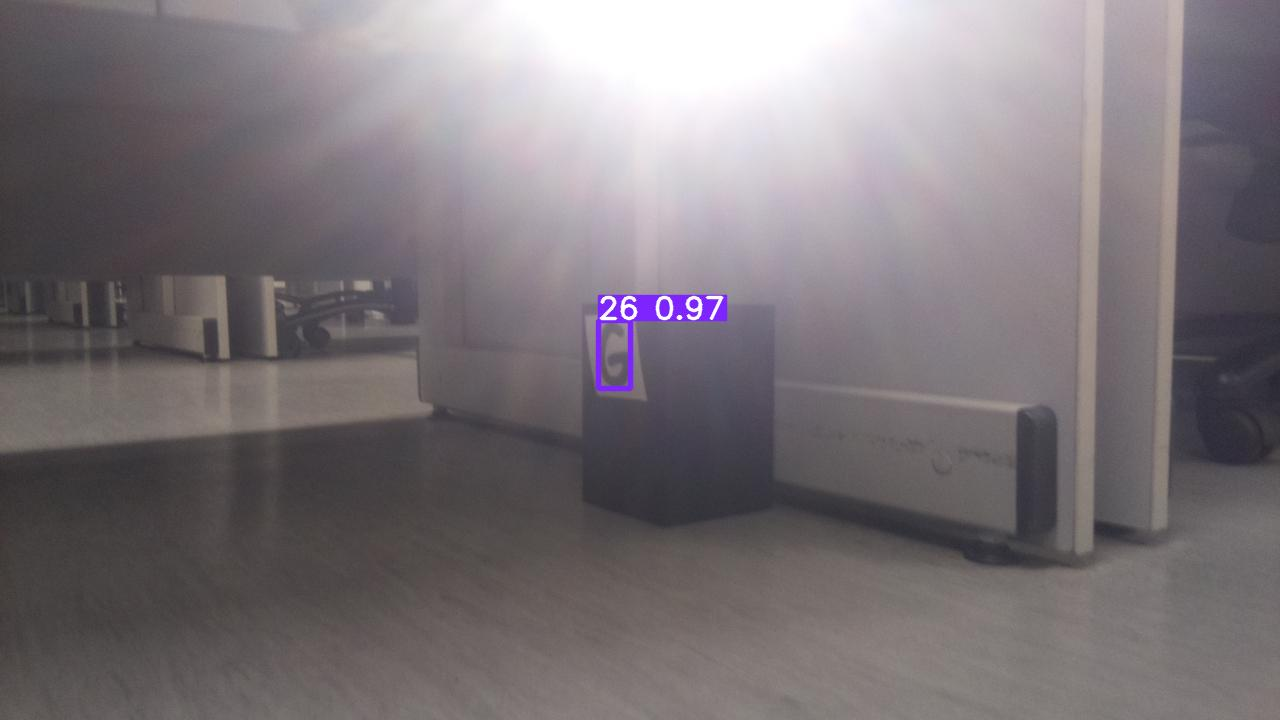

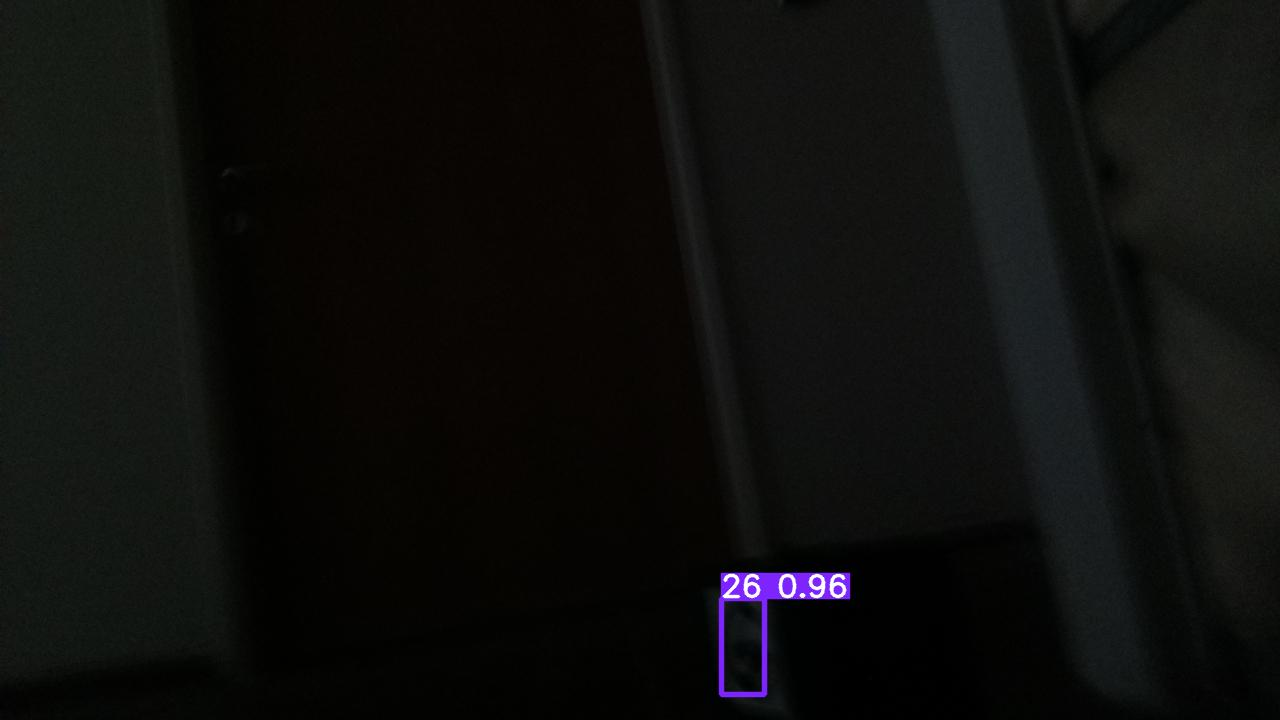

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_273


✅ Class 27: saved 3 preds to /content/yolov5/runs/detect_by_class/class_27


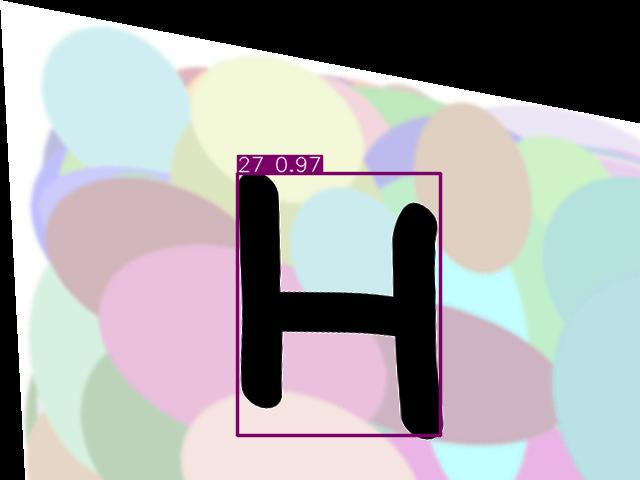

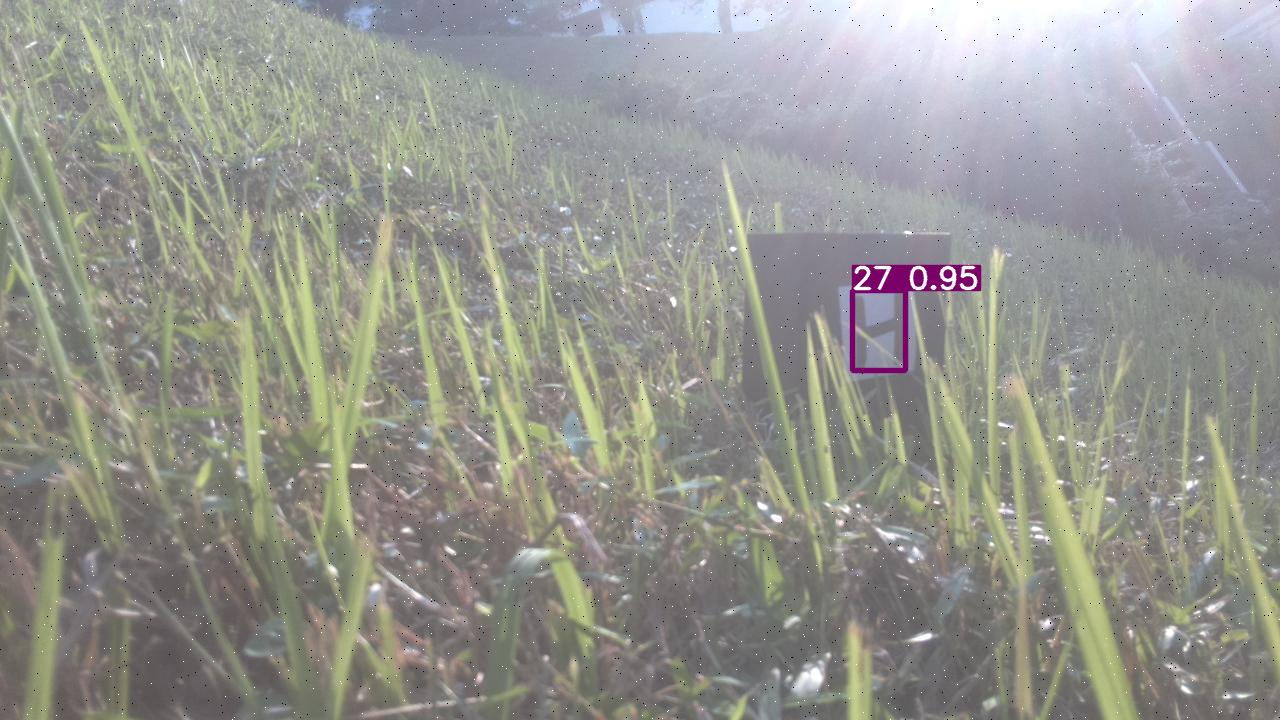

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_283


✅ Class 28: saved 3 preds to /content/yolov5/runs/detect_by_class/class_28


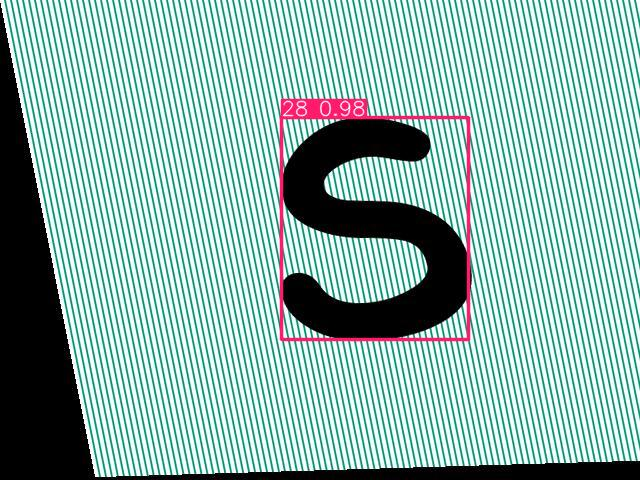

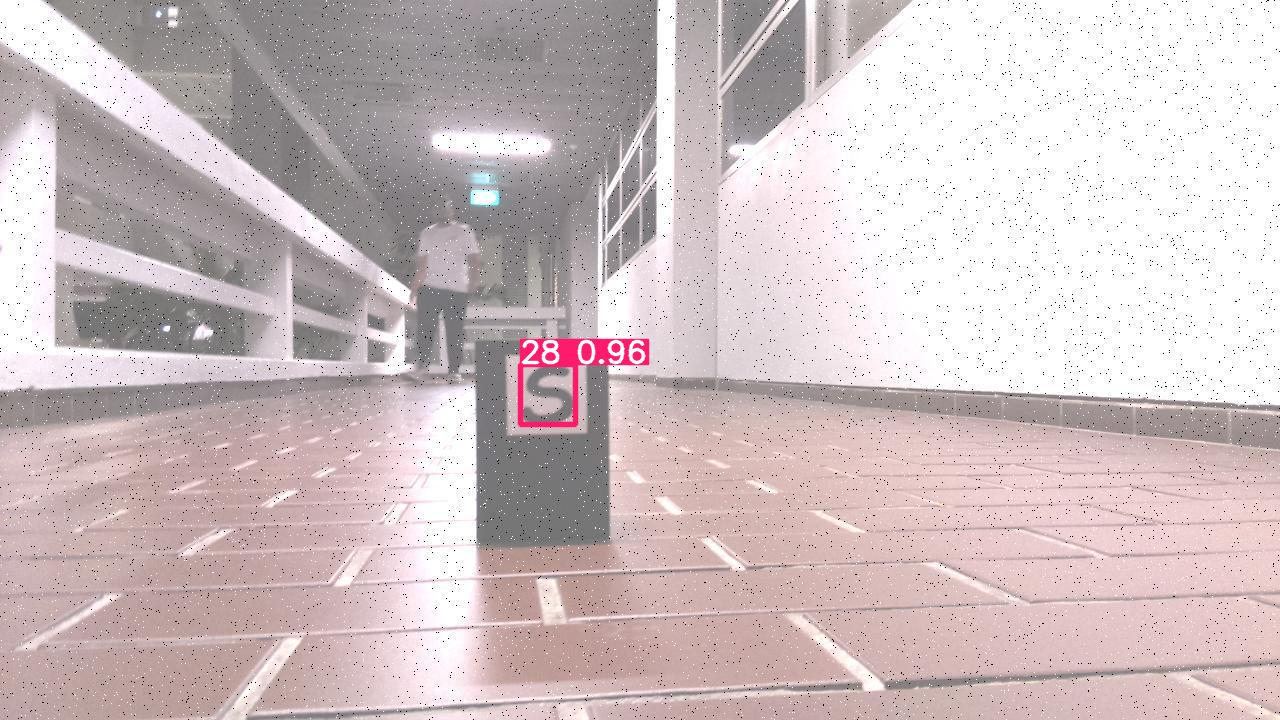

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_293


✅ Class 29: saved 3 preds to /content/yolov5/runs/detect_by_class/class_29


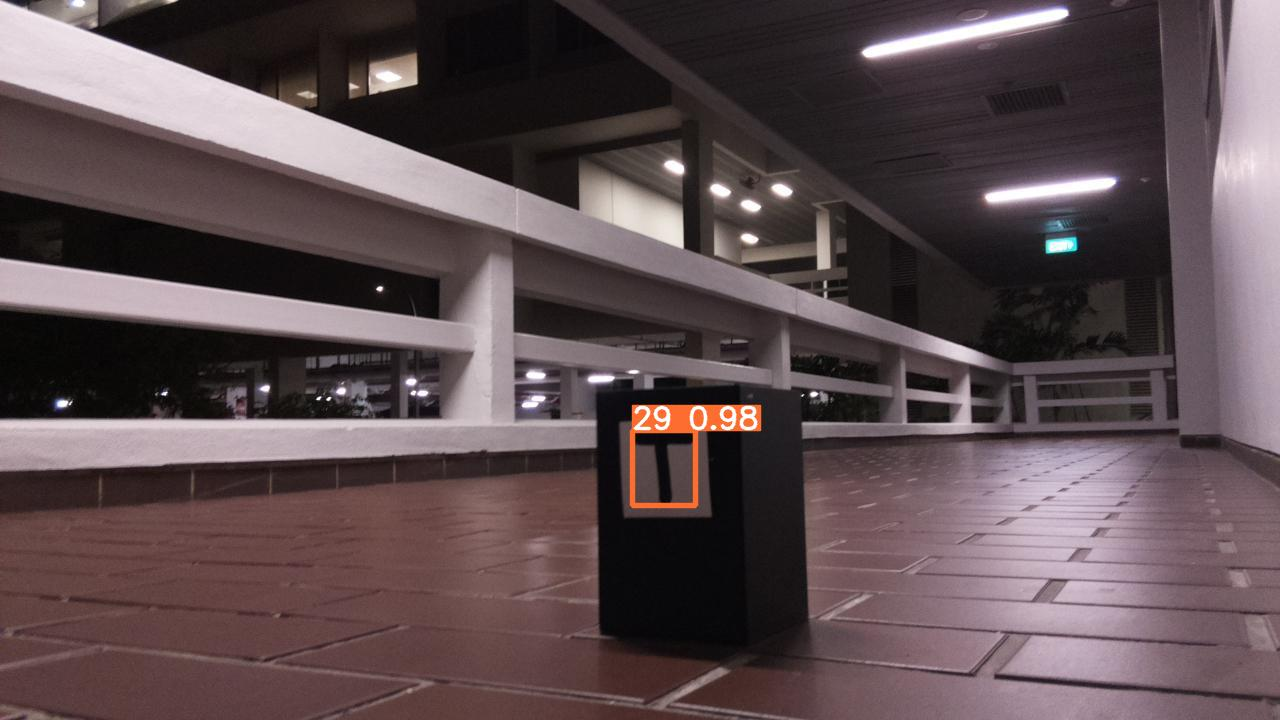

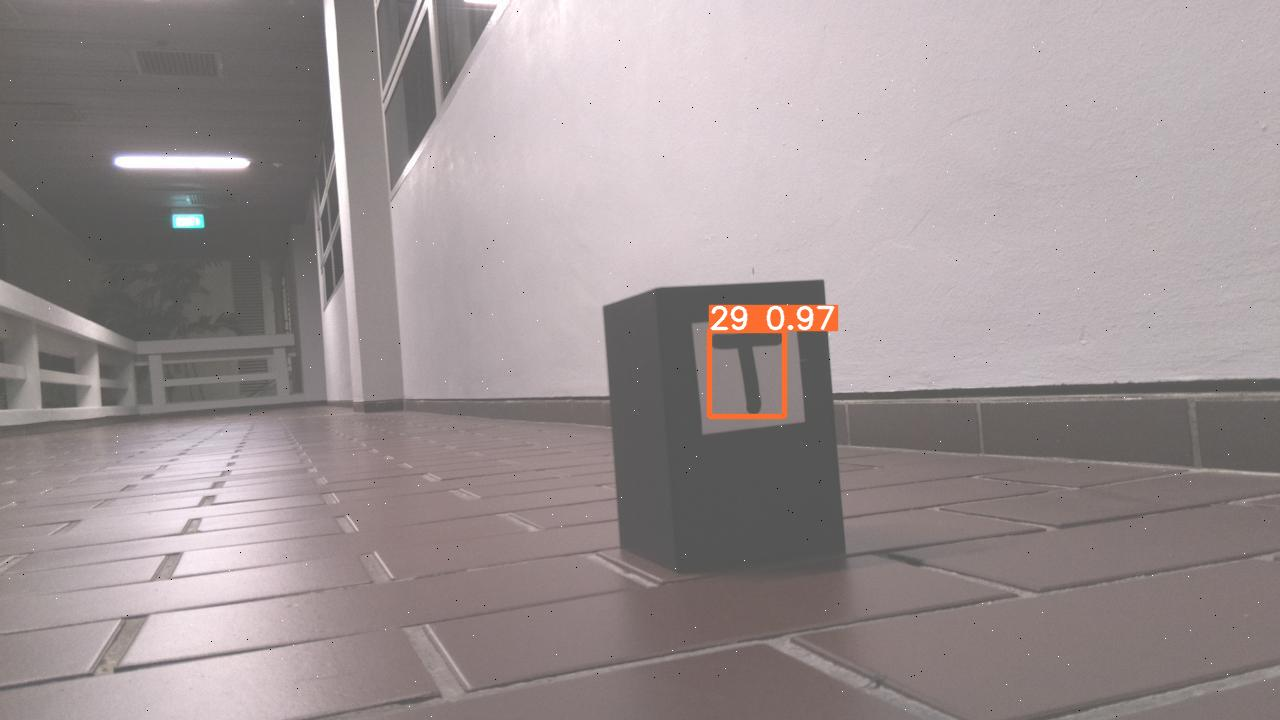

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_303


✅ Class 30: saved 3 preds to /content/yolov5/runs/detect_by_class/class_30


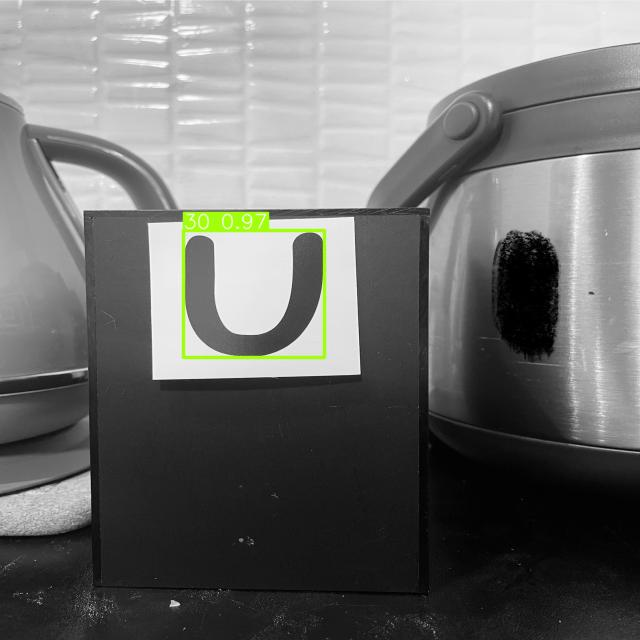

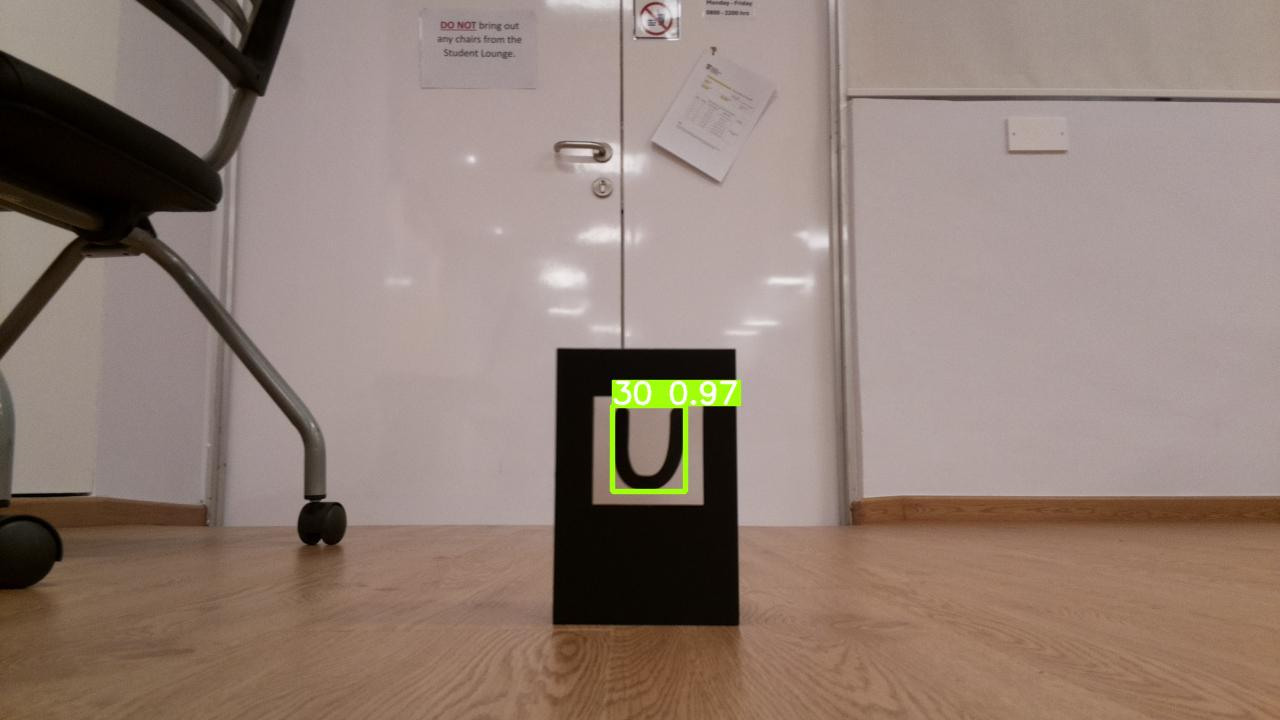

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_313


✅ Class 31: saved 3 preds to /content/yolov5/runs/detect_by_class/class_31


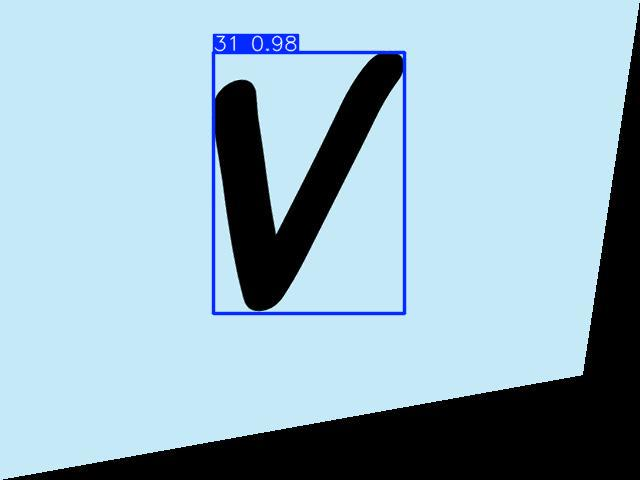

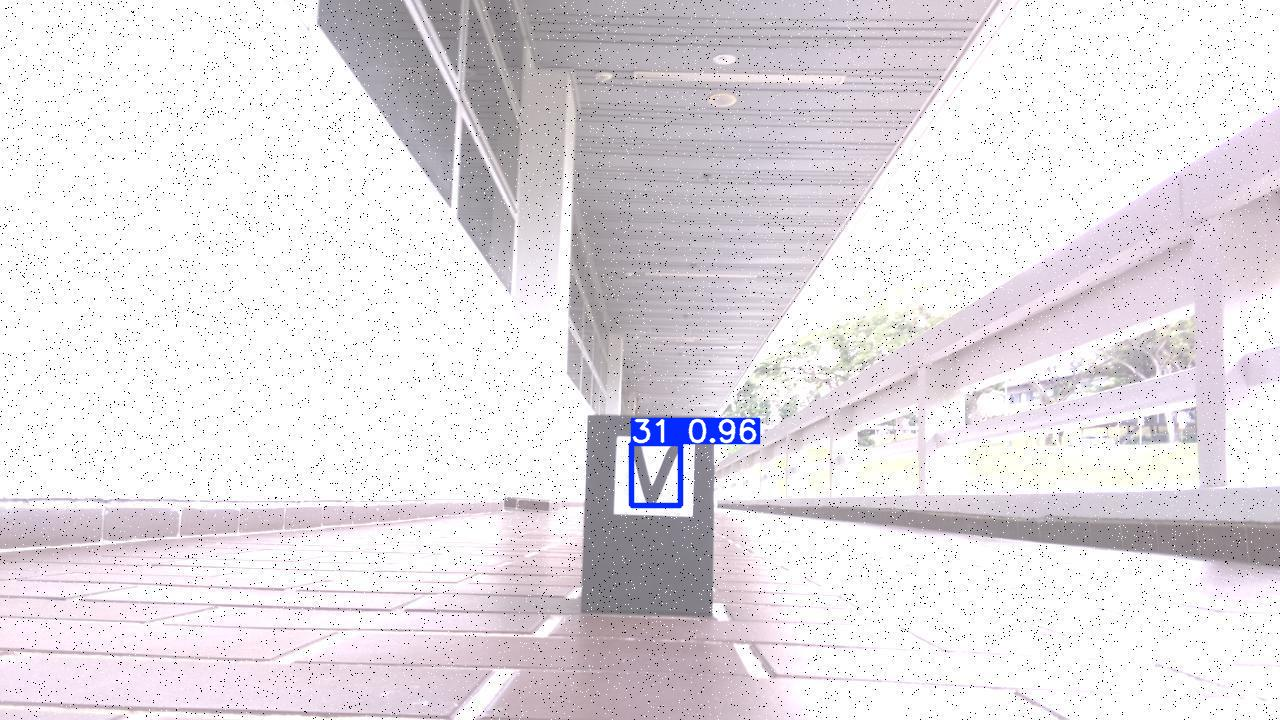

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_323


✅ Class 32: saved 3 preds to /content/yolov5/runs/detect_by_class/class_32


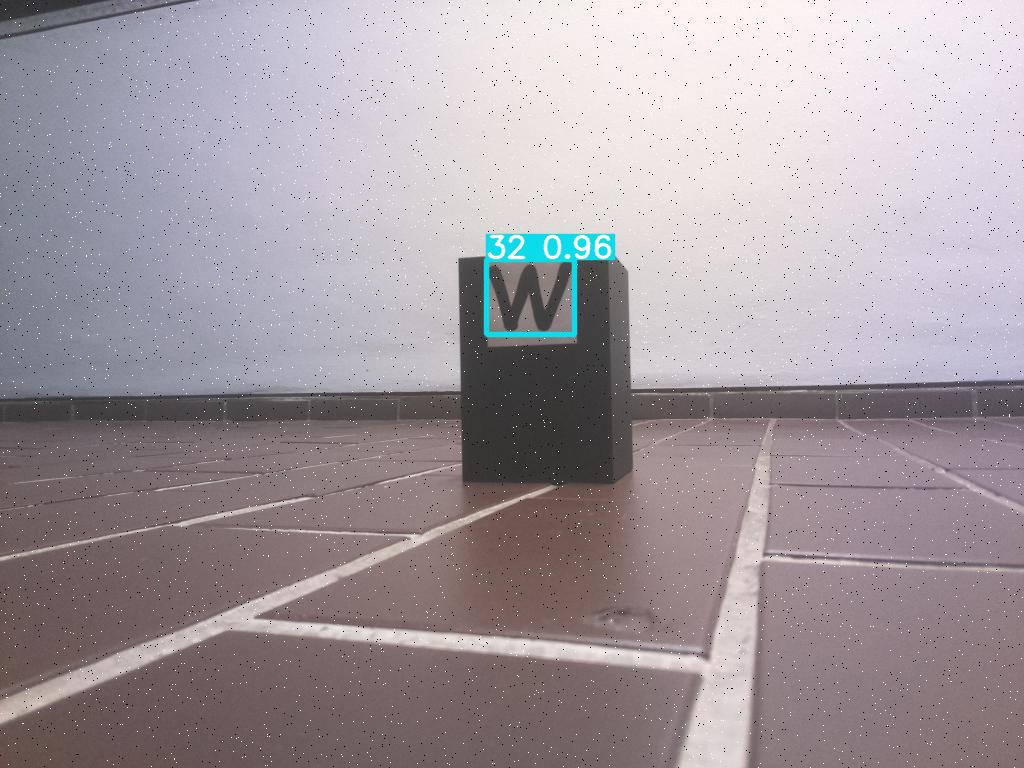

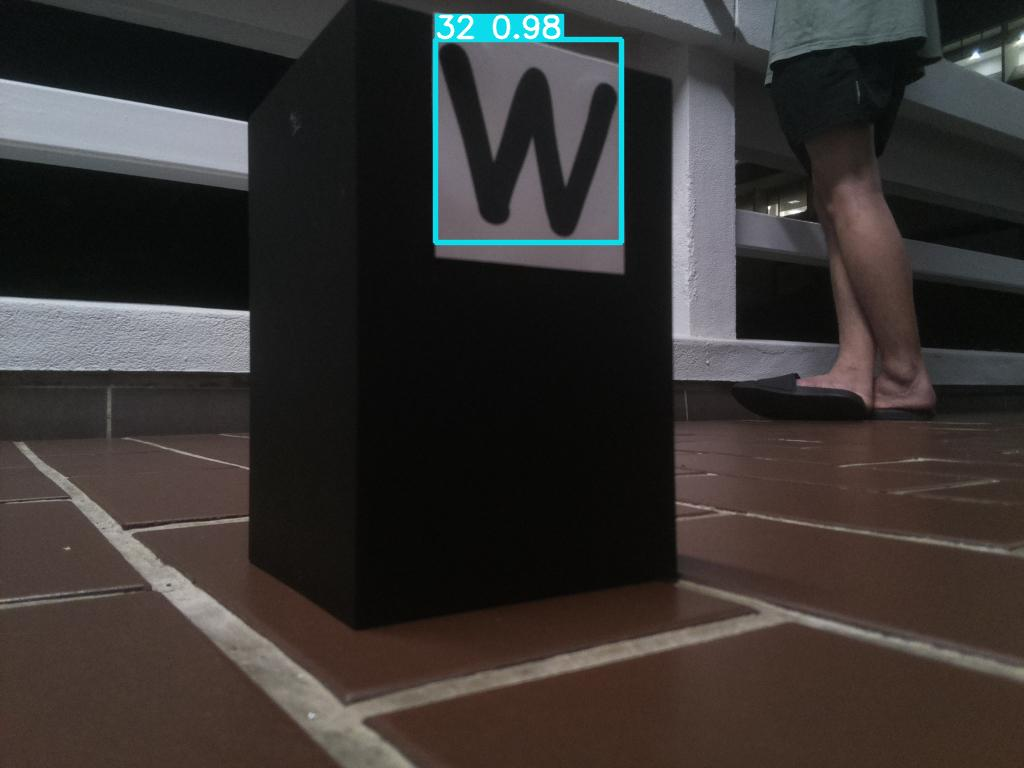

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_333


✅ Class 33: saved 3 preds to /content/yolov5/runs/detect_by_class/class_33


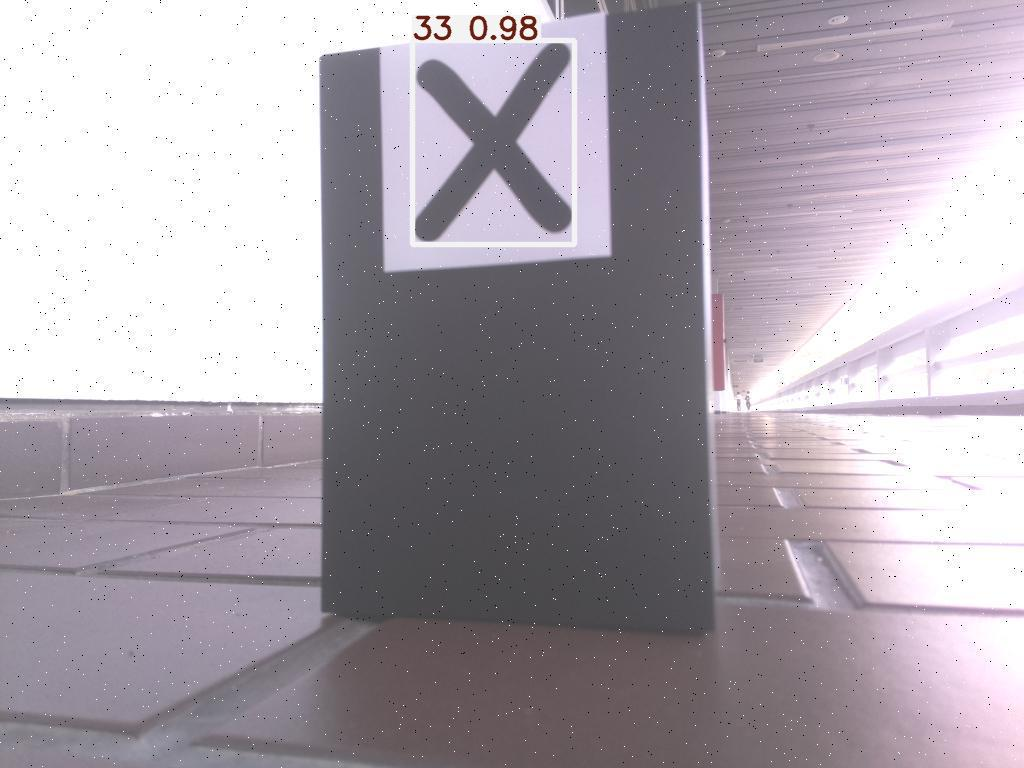

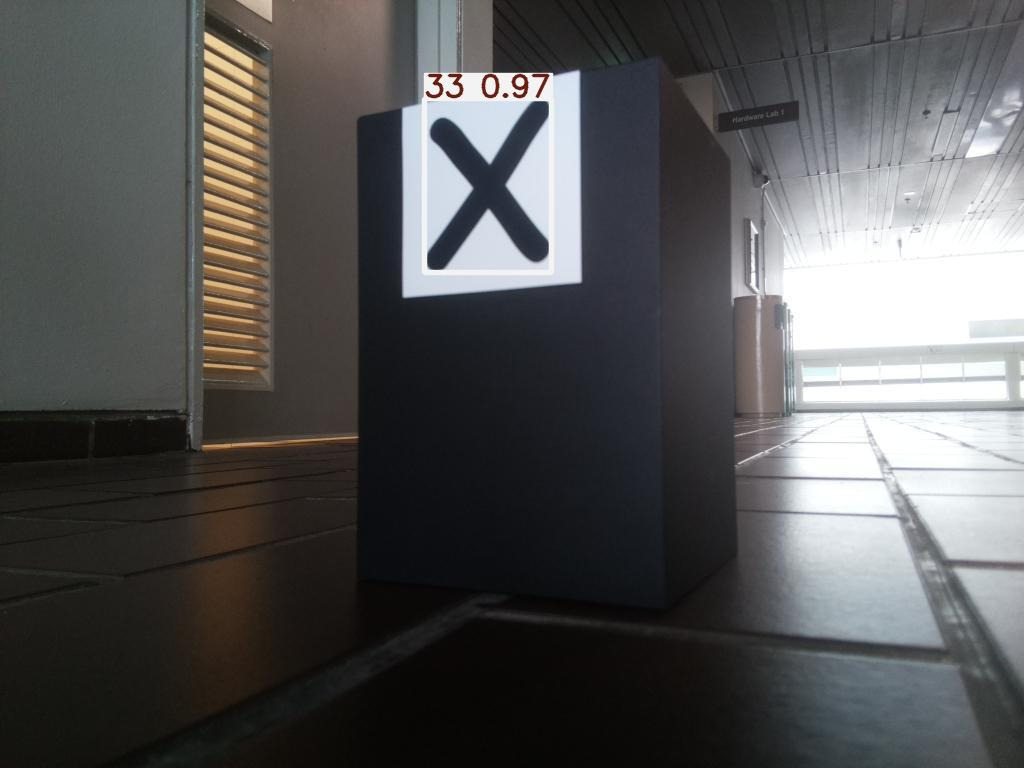

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_343


✅ Class 34: saved 3 preds to /content/yolov5/runs/detect_by_class/class_34


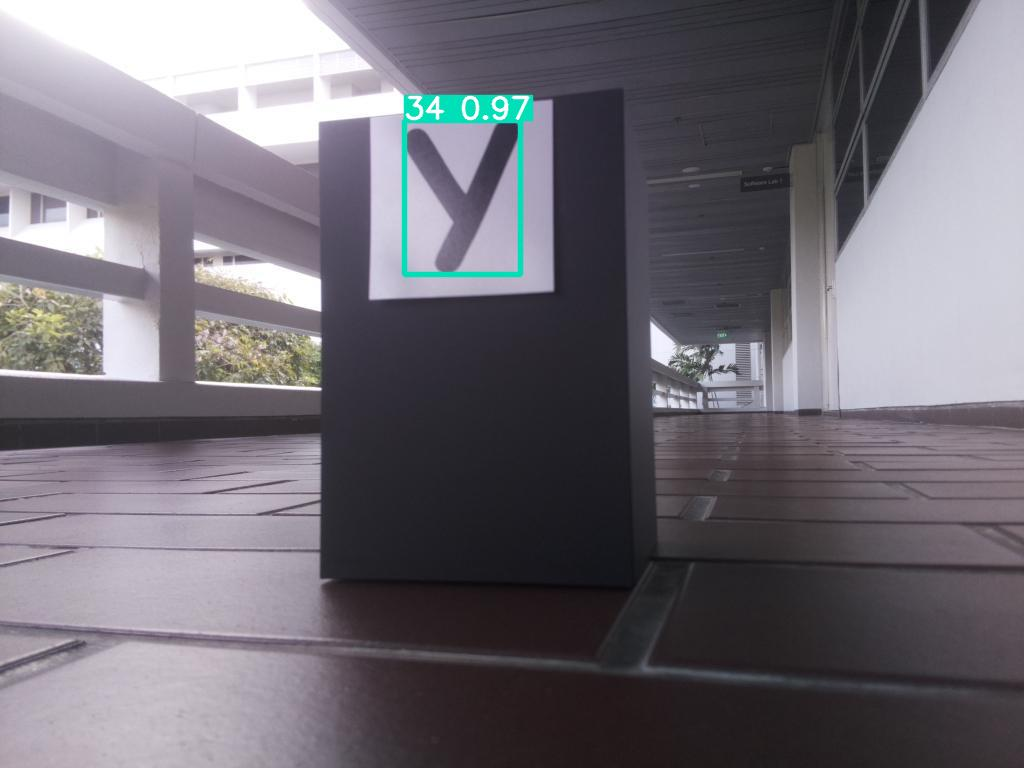

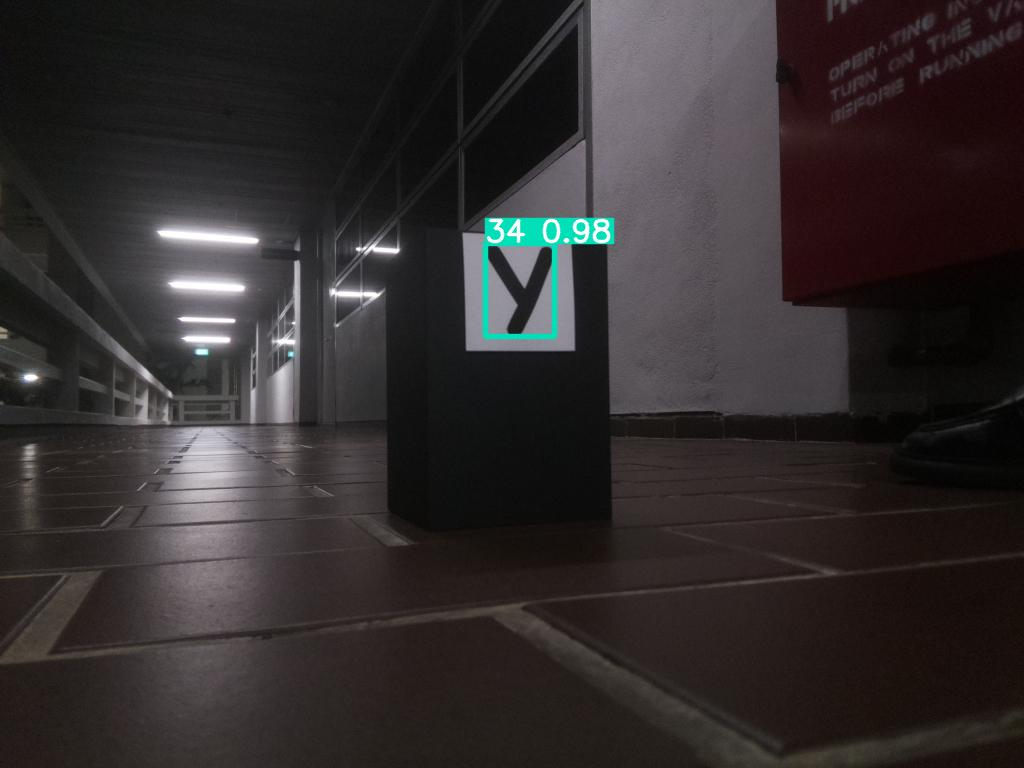

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_353


✅ Class 35: saved 3 preds to /content/yolov5/runs/detect_by_class/class_35


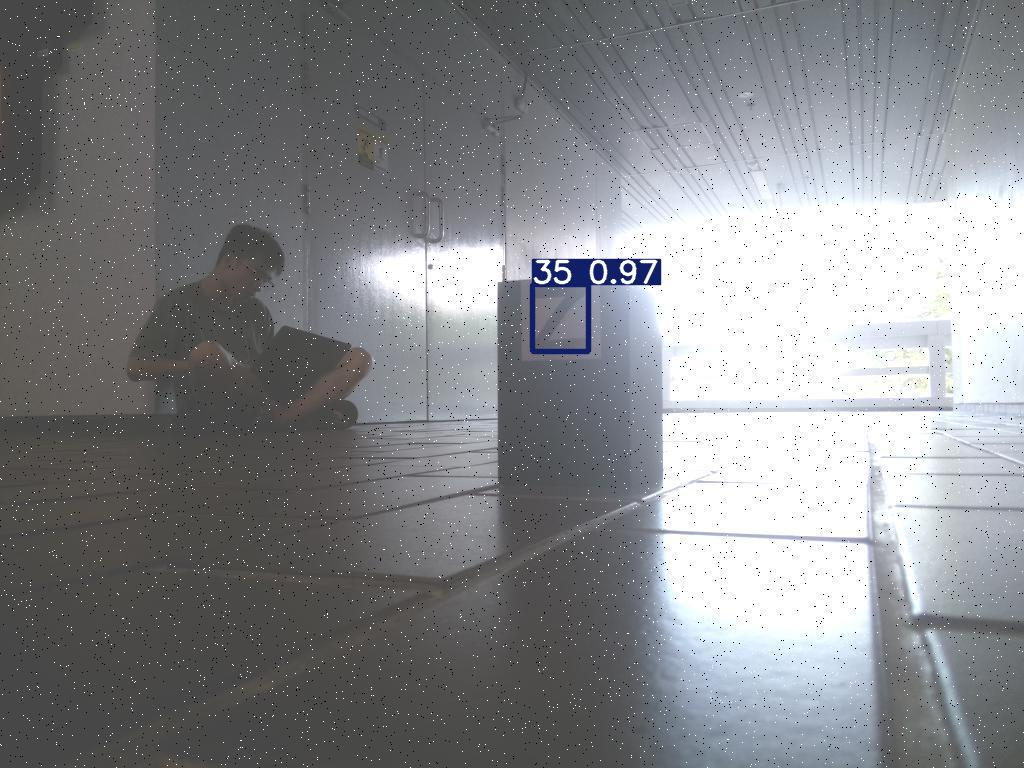

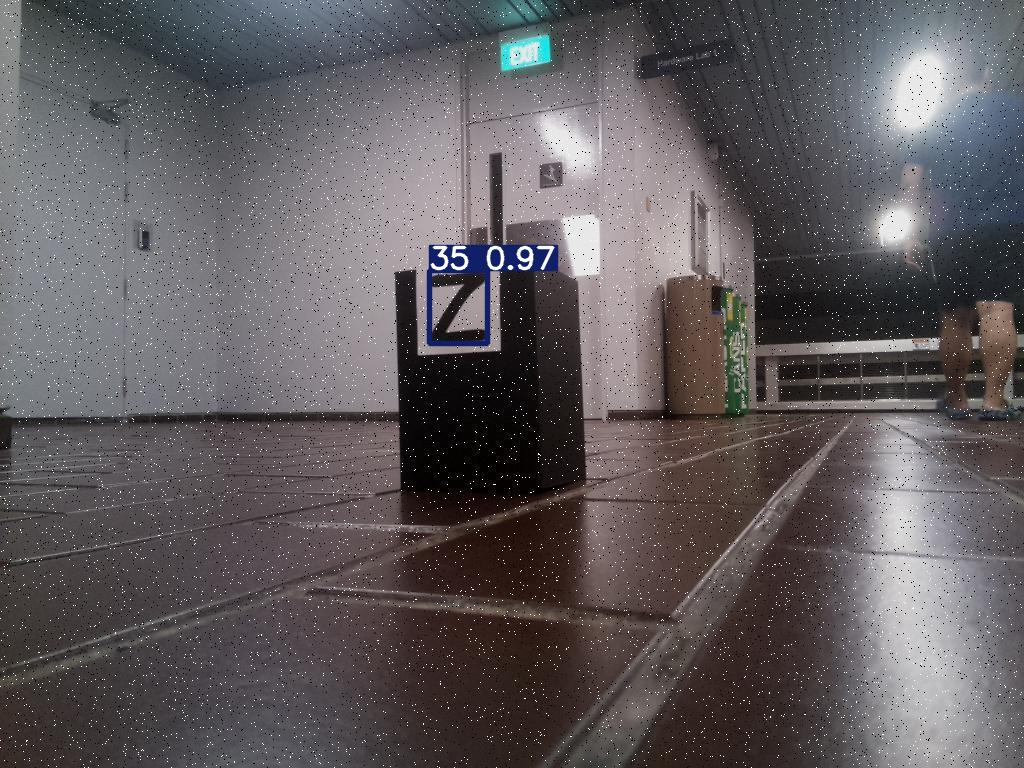

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_363


✅ Class 36: saved 3 preds to /content/yolov5/runs/detect_by_class/class_36


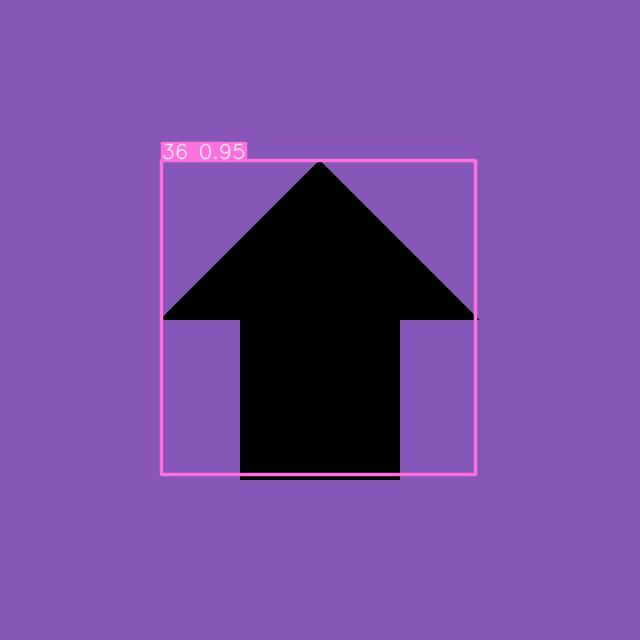

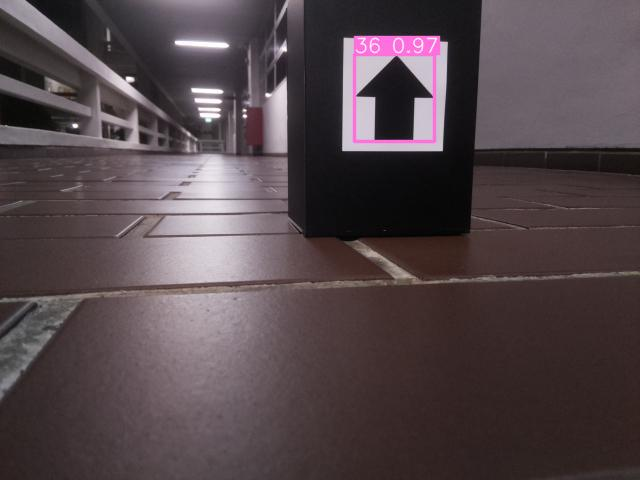

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_373


✅ Class 37: saved 3 preds to /content/yolov5/runs/detect_by_class/class_37


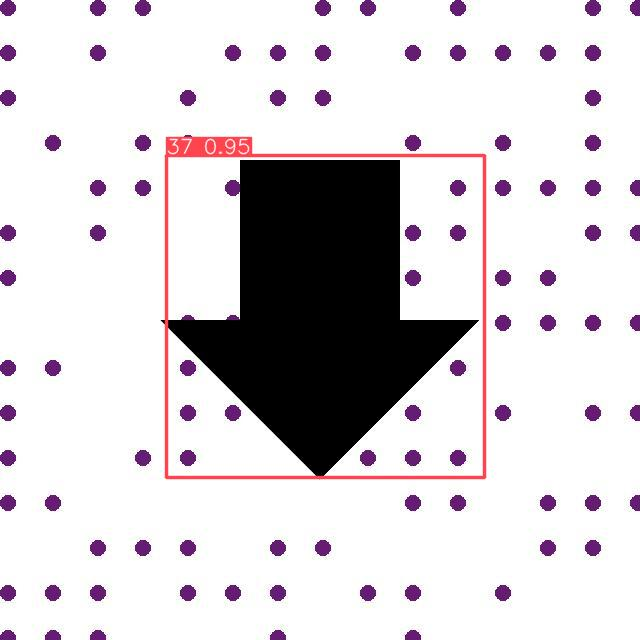

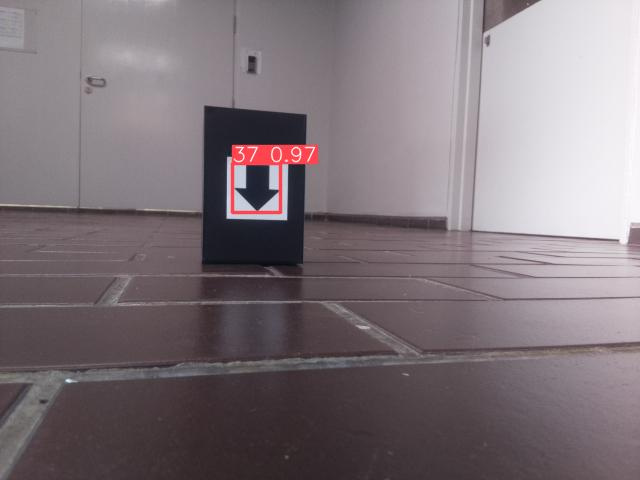

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_383


✅ Class 38: saved 3 preds to /content/yolov5/runs/detect_by_class/class_38


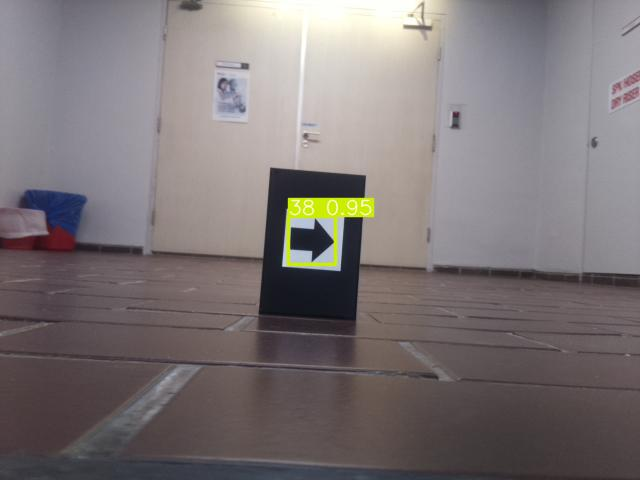

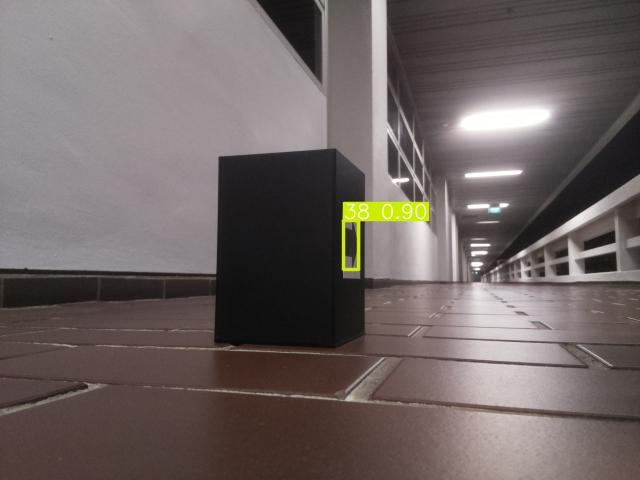

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_393


✅ Class 39: saved 3 preds to /content/yolov5/runs/detect_by_class/class_39


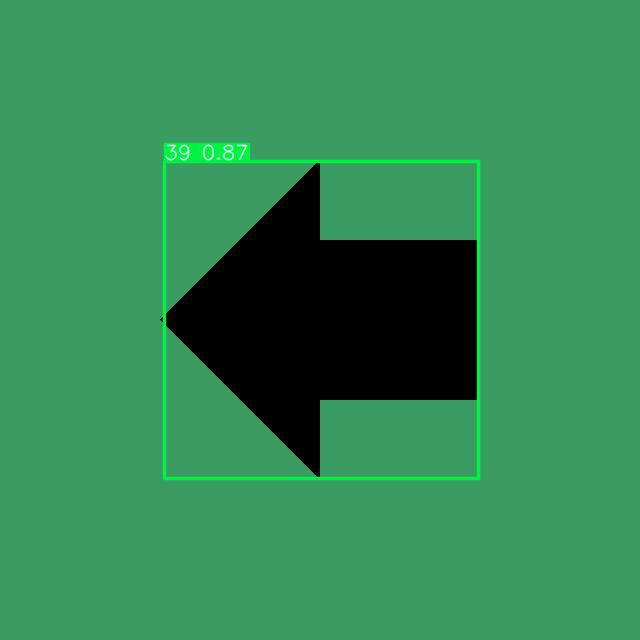

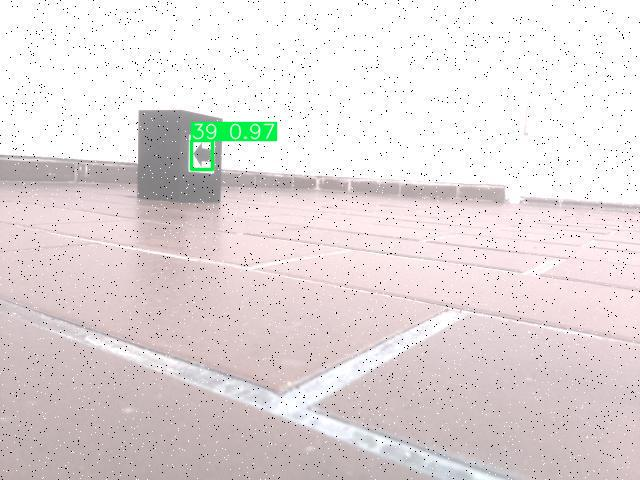

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_403


✅ Class 40: saved 3 preds to /content/yolov5/runs/detect_by_class/class_40


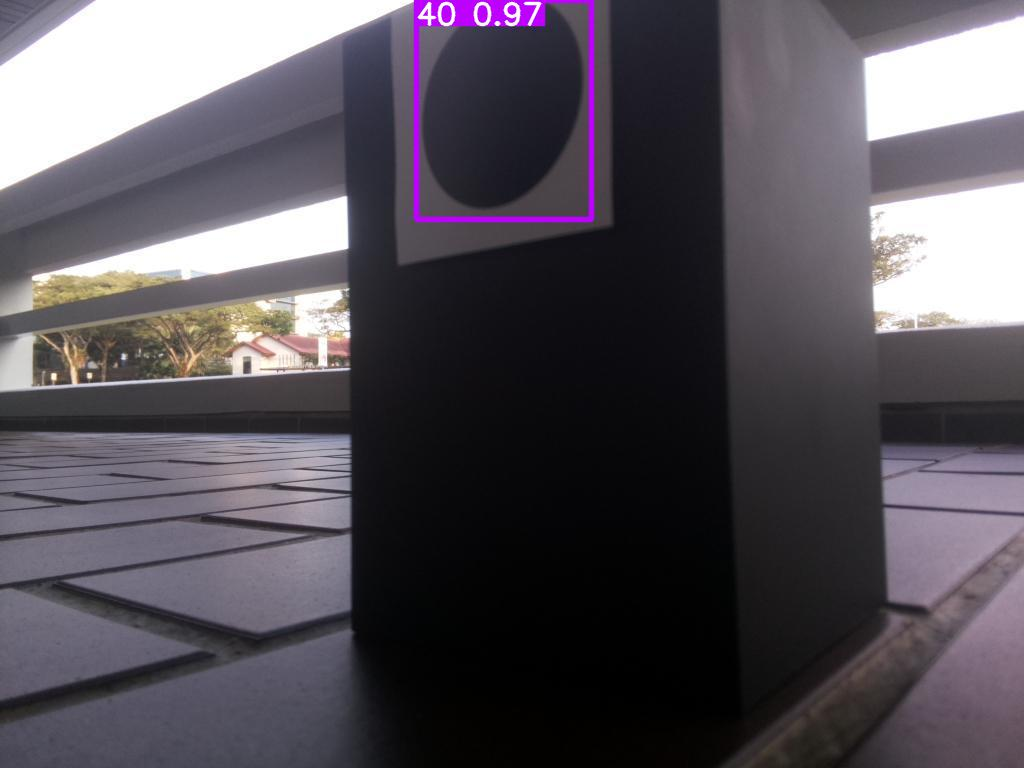

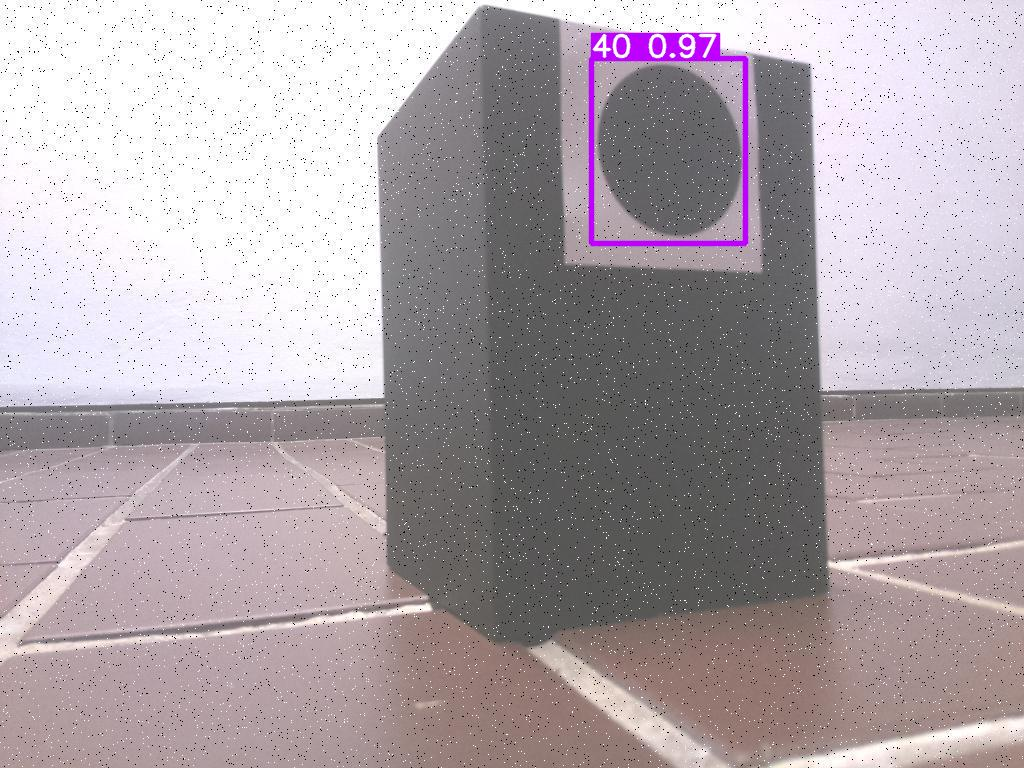

/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 3 images to /content/yolov5/runs/detect_by_class/class_marker3


✅ Class marker: saved 3 preds to /content/yolov5/runs/detect_by_class/class_marker


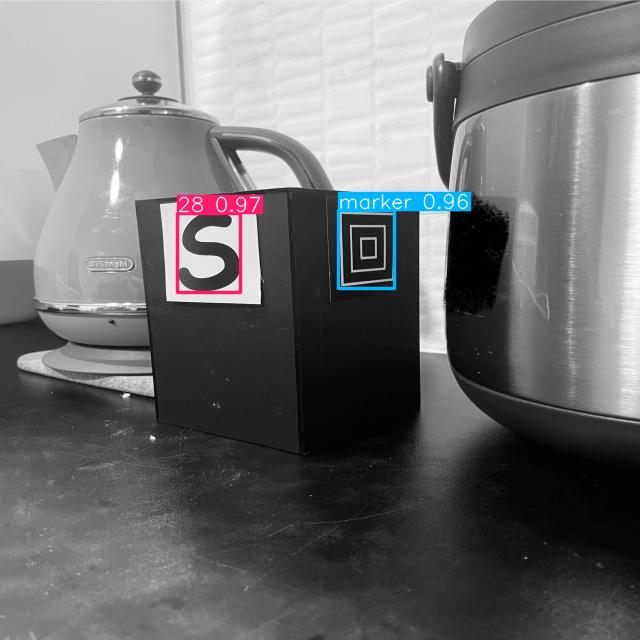

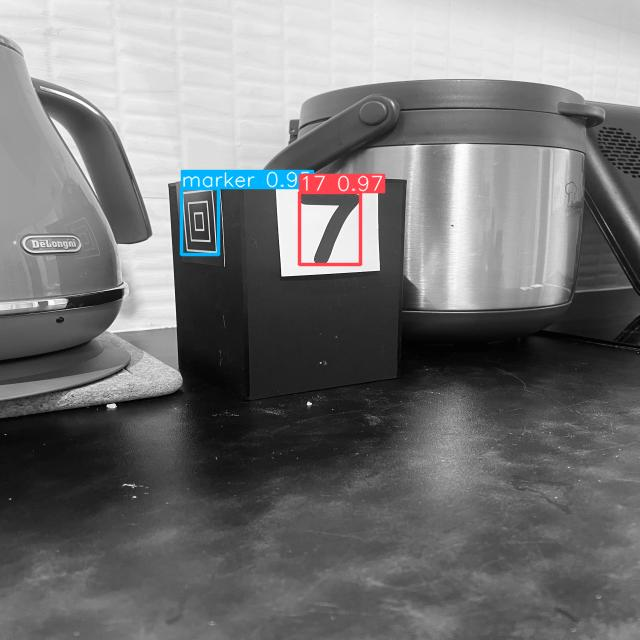


Done. Total images inferred: 93. Outputs under: /content/yolov5/runs/detect_by_class


In [38]:
# ==== sample & run a few images per class (reads absolute paths from patched_data.yaml) ====
BEST = "/content/drive/MyDrive/MDP_YOLO/runs/train/ananya_yolov5s/weights/best.pt"
DATA = "/content/patched_data.yaml"
K = 3                    # how many images per class to show
IMG_SIZE = 640           # inference size

import os, glob, random, yaml
from pathlib import Path
from IPython.display import Image as IPImage, display
import torch

# 1) read absolute dirs directly from YAML
with open(DATA) as f:
    cfg = yaml.safe_load(f)

split_key = "test" if "test" in cfg else ("val" if "val" in cfg else "valid")
img_dir = Path(cfg[split_key]).resolve()
# ensure we point to the images directory (some YAMLs give the parent)
if img_dir.name != "images":
    img_dir = img_dir / "images"
lbl_dir = img_dir.parent / "labels"

assert img_dir.exists(), f"Images dir not found: {img_dir}"
assert lbl_dir.exists(), f"Labels dir not found: {lbl_dir}"
names = cfg["names"]
print(f"Using split: {split_key} | images: {img_dir}")

# 2) build candidate image list per class by scanning label txts
def label_to_image_path(stem: str) -> str | None:
    for ext in (".jpg", ".jpeg", ".png", ".JPG", ".PNG", ".bmp"):
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return str(p)
    return None

cands = {i: set() for i in range(len(names))}
for lbl_path in glob.glob(str(lbl_dir / "*.txt")):
    stem = Path(lbl_path).stem
    img_path = label_to_image_path(stem)
    if not img_path:
        continue
    with open(lbl_path) as f:
        for line in f:
            sp = line.strip().split()
            if len(sp) >= 5:
                try:
                    cls = int(float(sp[0]))
                    if 0 <= cls < len(names):
                        cands[cls].add(img_path)
                except:
                    pass

samples = {i: random.sample(list(v), min(K, len(v))) for i, v in cands.items()}

# 3) run inference once per class and save/preview
model = torch.hub.load('/content/yolov5', 'custom', path=BEST, source='local')
model.conf = 0.25
model.iou  = 0.45

out_root = Path("/content/yolov5/runs/detect_by_class")
out_root.mkdir(parents=True, exist_ok=True)

total_imgs = 0
for i, cls_name in enumerate(names):
    imgs = [p for p in samples[i] if p]
    if not imgs:
        print(f"⚠️  Class {cls_name}: no images found.")
        continue
    total_imgs += len(imgs)
    out_dir = out_root / f"class_{cls_name}"
    results = model(imgs, size=IMG_SIZE)
    results.save(save_dir=str(out_dir))
    print(f"✅ Class {cls_name}: saved {len(imgs)} preds to {out_dir}")

    # show up to 2 previews
    for p in sorted(glob.glob(str(out_dir / '*.jpg')))[:2]:
        display(IPImage(filename=p))

print(f"\nDone. Total images inferred: {total_imgs}. Outputs under: {out_root}")
